In [1]:
import sys
import logging
import json
import numpy as np
import pandas as pd
from datetime import datetime
import time

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS
import sext_tools as st
from gen3_shared import prepare, get_eval_f, compute_family_k2l_from_knob_k2l, get_raw_eval_f

logger = logging.getLogger(__name__)

### SETUP

In [2]:
MODE = 'DW_SH1N_SH3N_SH4N_SL1_SL2P12345_SL3P12345_SH1DW081828_SH3DW081828_SH4DW081828'
NAME_ROOT = f'mobo_{MODE}_v1'

from apsopt.util.log import prepare_loggers
prepare_loggers()
fh = logging.FileHandler(f'logs/{NAME_ROOT}_{datetime.now():%Y%m%dT%H%M%S}.optlog', mode='w')
fh.setLevel(logging.NOTSET)
logging.getLogger().addHandler(fh)

dfknobs, ivals_ref, ivals, gvocs, iknobvals = prepare(MODE)
variables = gvocs.variables

reference_point = {'LT': 3.0, # hours
                   'EFF': 10.0 # % injected
                   }

display(pd.DataFrame(ivals_ref,index=[0]))
display(pd.DataFrame(variables))

,SH1N,SH3N,SH4N,SL1,SL2-P1,SL2-P2,SL2-P3,SL2-P4,SL2-P5,SL3-P1,...,SL3-P5,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,SH3-DW18,SH3-DW28,SH4-DW08,SH4-DW18,SH4-DW28
0,3.966582,-1.171022,-3.16418,-2.654321,7.135584,7.135584,7.135584,7.135584,7.135584,-5.892172,...,-5.892172,3.966582,3.966582,3.966582,-1.171022,-1.171022,-1.171022,-3.16418,-3.16418,-3.16418


,SH1N,SH3N,SH4N,SL1,SL2-P1,SL2-P2,SL2-P3,SL2-P4,SL2-P5,SL3-P1,...,SL3-P5,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,SH3-DW18,SH3-DW28,SH4-DW08,SH4-DW18,SH4-DW28
0,-0.47599,-0.140523,-0.379702,-0.318519,-0.85627,-0.85627,-0.85627,-0.85627,-0.85627,-0.707061,...,-0.707061,-0.47599,-0.47599,-0.47599,-0.140523,-0.140523,-0.140523,-0.379702,-0.379702,-0.379702
1,0.47599,0.140523,0.379702,0.318519,0.85627,0.85627,0.85627,0.85627,0.85627,0.707061,...,0.707061,0.47599,0.47599,0.47599,0.140523,0.140523,0.140523,0.379702,0.379702,0.379702


In [3]:
#TEST_MODE = True
TEST_MODE = False

In [4]:
inputs_dict = compute_family_k2l_from_knob_k2l(
    dfknobs, {k:variables[k][0] for k in variables.keys()}, ivals, True)
inputs_dict

SH1N   : +3.967 + -0.476 -> +3.491
SH3N   : -1.171 + -0.141 -> -1.312
SH4N   : -3.164 + -0.380 -> -3.544
SL1    : -2.654 + -0.319 -> -2.973
SL2-P1 : +7.136 + -0.856 -> +6.279
SL2-P2 : +7.136 + -0.856 -> +6.279
SL2-P3 : +7.136 + -0.856 -> +6.279
SL2-P4 : +7.136 + -0.856 -> +6.279
SL2-P5 : +7.136 + -0.856 -> +6.279
SL3-P1 : -5.892 + -0.707 -> -6.599
SL3-P2 : -5.892 + -0.707 -> -6.599
SL3-P3 : -5.892 + -0.707 -> -6.599
SL3-P4 : -5.892 + -0.707 -> -6.599
SL3-P5 : -5.892 + -0.707 -> -6.599
SH1-DW08: +3.967 + -0.476 -> +3.491
SH1-DW18: +3.967 + -0.476 -> +3.491
SH1-DW28: +3.967 + -0.476 -> +3.491
SH3-DW08: -1.171 + -0.141 -> -1.312
SH3-DW18: -1.171 + -0.141 -> -1.312
SH3-DW28: -1.171 + -0.141 -> -1.312
SH4-DW08: -3.164 + -0.380 -> -3.544
SH4-DW18: -3.164 + -0.380 -> -3.544
SH4-DW28: -3.164 + -0.380 -> -3.544


{'SH1N': 3.4905925296,
 'SH3N': -1.31154428384,
 'SH4N': -3.54388175904,
 'SL1': -2.9728397552000003,
 'SL2-P1': 6.279314175200001,
 'SL2-P2': 6.279314175200001,
 'SL2-P3': 6.279314175200001,
 'SL2-P4': 6.279314175200001,
 'SL2-P5': 6.279314175200001,
 'SL3-P1': -6.599232776640001,
 'SL3-P2': -6.599232776640001,
 'SL3-P3': -6.599232776640001,
 'SL3-P4': -6.599232776640001,
 'SL3-P5': -6.599232776640001,
 'SH1-DW08': 3.4905925296,
 'SH1-DW18': 3.4905925296,
 'SH1-DW28': 3.4905925296,
 'SH3-DW08': -1.31154428384,
 'SH3-DW18': -1.31154428384,
 'SH3-DW28': -1.31154428384,
 'SH4-DW08': -3.54388175904,
 'SH4-DW18': -3.54388175904,
 'SH4-DW28': -3.54388175904}

### Test eval function

In [5]:
# Test
if False and not TEST_MODE:
    raw_eval_f = get_raw_eval_f()
    raw_eval_f(inputs_dict, meas_bxb_tunes=True, meas_lifetime=True, meas_inj_eff=True)

In [7]:
eval_f = get_eval_f(TEST_MODE, gvocs, dfknobs, ivals)
ev = FunctionEvaluator(script=eval_f)

generator_name = 'aps_mobo'
gc = get_generator_class(generator_name)
gen = gc(gvocs=gvocs)
gen.numerical_optimizer.n_raw_samples = 256 #512
gen.numerical_optimizer.n_restarts = 25
gen.gp_constructor.use_low_noise_prior = False
gen.gp_constructor.use_high_noise_prior = False
gen.max_travel_distances = [1.0] * len(gvocs.variables_active)
gen.reference_point = reference_point

[INFO ][23:27:50.691 generator.   16] Initializing generator aps_mobo
[INFO ][23:27:50.694 generator.   64] Initialized generator aps_mobo


In [8]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options, generator=gen, evaluator=ev, gvocs=gvocs)

[DEBUG][23:27:55.328 optimizer.   83] Initializing optimizer with tag='7445a0f2c5' store_history=True dump_every_step=True history_directory=None execution_mode='sync'
[DEBUG][23:27:55.330 optimizer.  138] Generator set to: supports_batch_generation=True supports_multi_objective=True vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1': [-0.31851854520000006, 0.31851854520000006], 'SL2-P1': [-0.8562701148, 0.8562701148], 'SL2-P2': [-0.8562701148, 0.8562701148], 'SL2-P3': [-0.8562701148, 0.8562701148], 'SL2-P4': [-0.8562701148, 0.8562701148], 'SL2-P5': [-0.8562701148, 0.8562701148], 'SL3-P1': [-0.70706065464, 0.70706065464], 'SL3-P2': [-0.70706065464, 0.70706065464], 'SL3-P3': [-0.70706065464, 0.70706065464], 'SL3-P4': [-0.70706065464, 0.70706065464], 'SL3-P5': [-0.70706065464, 0.70706065464], 'SH1-DW08': [-0.4759898904, 0.4759898904], 'SH1-DW18': [-0.4759898904, 0.4759898904], 'SH

### Sample at initial values

In [9]:
opt.generate_at(iknobvals)
opt.evaluate_data()

[INFO ][23:27:59.082 optimizer.  577] Evaluating 1 inputs
[DEBUG][23:27:59.084 evaluators  193] Data kwargs: row={'SH1N': -0.05, 'SH3N': 0.05, 'SH4N': -0.04, 'SL1': 0.08, 'SL2-P1': -0.27, 'SL2-P2': -0.34, 'SL2-P3': -0.41000000000000003, 'SL2-P4': -0.48000000000000004, 'SL2-P5': -0.55, 'SL3-P1': 0.13, 'SL3-P2': 0.06, 'SL3-P3': -0.010000000000000009, 'SL3-P4': -0.08000000000000002, 'SL3-P5': -0.15000000000000002, 'SH1-DW08': 0.025, 'SH1-DW18': -0.025, 'SH1-DW28': -0.025, 'SH3-DW08': 0.025, 'SH3-DW18': -0.025, 'SH3-DW28': -0.025, 'SH4-DW08': 0.025, 'SH4-DW18': -0.025, 'SH4-DW28': -0.025}
[INFO ][23:27:59.091 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.9165824200000006, 'SH3N': -1.1210216819999999, 'SH4N': -3.2041801420000002, 'SL1': -2.5743212100000004, 'SL2-P1': 6.865584290000001, 'SL2-P2': 6.795584290000001, 'SL2-P3': 6.7255842900000005, 'SL2-P4': 6.65558429, 'SL2-P5': 6.585584290000001, 'SL3-P1': -5.762172122000001, 'SL3-P2': -5.832172122000001, 'SL3-P3': -5.9021721220000005, 'SL

SH1N   : +3.967 + -0.050 -> +3.917
SH3N   : -1.171 + +0.050 -> -1.121
SH4N   : -3.164 + -0.040 -> -3.204
SL1    : -2.654 + +0.080 -> -2.574
SL2-P1 : +7.136 + -0.270 -> +6.866
SL2-P2 : +7.136 + -0.340 -> +6.796
SL2-P3 : +7.136 + -0.410 -> +6.726
SL2-P4 : +7.136 + -0.480 -> +6.656
SL2-P5 : +7.136 + -0.550 -> +6.586
SL3-P1 : -5.892 + +0.130 -> -5.762
SL3-P2 : -5.892 + +0.060 -> -5.832
SL3-P3 : -5.892 + -0.010 -> -5.902
SL3-P4 : -5.892 + -0.080 -> -5.972
SL3-P5 : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.025 -> +3.992
SH1-DW18: +3.967 + -0.025 -> +3.942
SH1-DW28: +3.967 + -0.025 -> +3.942
SH3-DW08: -1.171 + +0.025 -> -1.146
SH3-DW18: -1.171 + -0.025 -> -1.196
SH3-DW28: -1.171 + -0.025 -> -1.196
SH4-DW08: -3.164 + +0.025 -> -3.139
SH4-DW18: -3.164 + -0.025 -> -3.189
SH4-DW28: -3.164 + -0.025 -> -3.189
Sextupole adj. took 0.0.
Max FCOR I [A] = 0.007; RMS(dx, dy) [m] = (9.969e-07, 1.133e-06)
Orbit correction converged


[INFO ][23:28:03.197 opt_funcs.  734] Lifetime measurement START
[INFO ][23:28:11.182 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 5.382 (raw tau [hr] = 5.983, epsy [pm] = 16.67) (took 8.0 [s])
Inj. Eff. = 3.68 (took 17.0 [s])
Eval. func. finished.


[DEBUG][23:28:28.226 evaluators  211] Result: output={'result': {'_nux': 0.20902886064372184, '_nuy': 0.26611163180313757, '_eps_x_bxbOn': 9.99752832985665e-10, '_eps_y_bxbOn': 1.6742616929958973e-11, '_eps_x_bxbOff': 9.999940485143326e-10, '_eps_y_bxbOff': 1.6668446292298487e-11, 'LT': 5.38157002005309, '_raw_LT': 5.983297174657699, 'EFF': 3.6757599027264476}, 'exception': None, 'traceback': '', 'wall_time': 29.14073430467397, 'cpu_time': 14.078207824}
[DEBUG][23:28:28.229 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][23:28:28.241 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00000.json] in [0.00916]s


In [10]:
assert opt.data.iloc[0].valid, f'ERROR: {opt.data.iloc[0].traceback}'
opt.data

,SH1N,SH3N,SH4N,SL1,SL2-P1,SL2-P2,SL2-P3,SL2-P4,SL2-P5,SL3-P1,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,-0.05,0.05,-0.04,0.08,-0.27,-0.34,-0.41,-0.48,-0.55,0.13,...,True,0.209029,0.266112,9.997528e-10,1.674262e-11,9.999940e-10,1.666845e-11,5.38157,5.983297,3.67576


### Sample close to initial point

In [11]:
mt = {k: 0.05 for k in variables.keys()}
opt.generate_random_around_point(n=7, point=iknobvals, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

[INFO ][23:28:43.220 optimizer.  577] Evaluating 7 inputs
[DEBUG][23:28:43.222 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0219226957360031, 'SH1-DW18': -0.007015486139231655, 'SH1-DW28': -0.03667872041876219, 'SH1N': -0.06502080077576744, 'SH3-DW08': 0.024208721118139133, 'SH3-DW18': -0.026580017060444765, 'SH3-DW28': -0.029667241207838396, 'SH3N': 0.04942535717109634, 'SH4-DW08': 0.03484957870357468, 'SH4-DW18': -0.04010091279463356, 'SH4-DW28': -0.012995060331409503, 'SH4N': -0.03331975075558646, 'SL1': 0.07841393907869962, 'SL2-P1': -0.27441946635495196, 'SL2-P2': -0.3267608362826435, 'SL2-P3': -0.3830800603150992, 'SL2-P4': -0.5160500561665929, 'SL2-P5': -0.5554271884778493, 'SL3-P1': 0.09860457044487494, 'SL3-P2': 0.07823654033197605, 'SL3-P3': 0.015321606458197044, 'SL3-P4': -0.050586172575760605, 'SL3-P5': -0.16148409305064848}
[INFO ][23:28:43.229 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.901561619224233, 'SH3N': -1.1215963248289036, 'SH4N': -3.1974998927555864, '

SH1N   : +3.967 + -0.065 -> +3.902
SH3N   : -1.171 + +0.049 -> -1.122
SH4N   : -3.164 + -0.033 -> -3.197
SL1    : -2.654 + +0.078 -> -2.576
SL2-P1 : +7.136 + -0.274 -> +6.861
SL2-P2 : +7.136 + -0.327 -> +6.809
SL2-P3 : +7.136 + -0.383 -> +6.753
SL2-P4 : +7.136 + -0.516 -> +6.620
SL2-P5 : +7.136 + -0.555 -> +6.580
SL3-P1 : -5.892 + +0.099 -> -5.794
SL3-P2 : -5.892 + +0.078 -> -5.814
SL3-P3 : -5.892 + +0.015 -> -5.877
SL3-P4 : -5.892 + -0.051 -> -5.943
SL3-P5 : -5.892 + -0.161 -> -6.054
SH1-DW08: +3.967 + +0.022 -> +3.989
SH1-DW18: +3.967 + -0.007 -> +3.960
SH1-DW28: +3.967 + -0.037 -> +3.930
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + -0.027 -> -1.198
SH3-DW28: -1.171 + -0.030 -> -1.201
SH4-DW08: -3.164 + +0.035 -> -3.129
SH4-DW18: -3.164 + -0.040 -> -3.204
SH4-DW28: -3.164 + -0.013 -> -3.177
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.007; RMS(dx, dy) [m] = (1.283e-06, 1.116e-06)
Orbit correction converged


[INFO ][23:28:47.308 opt_funcs.  734] Lifetime measurement START
[INFO ][23:28:52.765 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 5.220 (raw tau [hr] = 5.776, epsy [pm] = 16.47) (took 5.5 [s])
Inj. Eff. = 3.94 (took 15.0 [s])
Eval. func. finished.


[DEBUG][23:29:07.799 evaluators  211] Result: output={'result': {'_nux': 0.21359121182569926, '_nuy': 0.2658980155696538, '_eps_x_bxbOn': 9.959389616626826e-10, '_eps_y_bxbOn': 1.681571635713476e-11, '_eps_x_bxbOff': 1.0018748478284229e-09, '_eps_y_bxbOff': 1.646860596593462e-11, 'LT': 5.219645917187137, '_raw_LT': 5.7757624549705415, 'EFF': 3.93574218771895}, 'exception': None, 'traceback': '', 'wall_time': 24.575596015900373, 'cpu_time': 11.476926937000002}
[DEBUG][23:29:07.800 evaluators  193] Data kwargs: row={'SH1-DW08': 0.025979950408198123, 'SH1-DW18': -0.03819029194026452, 'SH1-DW28': -0.004144962397975349, 'SH1N': -0.03996670952526238, 'SH3-DW08': 0.030541567169839606, 'SH3-DW18': -0.018310410282221017, 'SH3-DW28': -0.023012235573988717, 'SH3N': 0.056956945078858234, 'SH4-DW08': 0.021854895599055, 'SH4-DW18': -0.017125160803061344, 'SH4-DW28': -0.043116399921832985, 'SH4N': -0.04472919467118065, 'SL1': 0.09032992995392132, 'SL2-P1': -0.2503482945565465, 'SL2-P2': -0.3694098387

SH1N   : +3.967 + -0.040 -> +3.927
SH3N   : -1.171 + +0.057 -> -1.114
SH4N   : -3.164 + -0.045 -> -3.209
SL1    : -2.654 + +0.090 -> -2.564
SL2-P1 : +7.136 + -0.250 -> +6.885
SL2-P2 : +7.136 + -0.369 -> +6.766
SL2-P3 : +7.136 + -0.433 -> +6.703
SL2-P4 : +7.136 + -0.478 -> +6.658
SL2-P5 : +7.136 + -0.540 -> +6.596
SL3-P1 : -5.892 + +0.152 -> -5.740
SL3-P2 : -5.892 + +0.030 -> -5.862
SL3-P3 : -5.892 + -0.039 -> -5.931
SL3-P4 : -5.892 + -0.101 -> -5.993
SL3-P5 : -5.892 + -0.127 -> -6.019
SH1-DW08: +3.967 + +0.026 -> +3.993
SH1-DW18: +3.967 + -0.038 -> +3.928
SH1-DW28: +3.967 + -0.004 -> +3.962
SH3-DW08: -1.171 + +0.031 -> -1.140
SH3-DW18: -1.171 + -0.018 -> -1.189
SH3-DW28: -1.171 + -0.023 -> -1.194
SH4-DW08: -3.164 + +0.022 -> -3.142
SH4-DW18: -3.164 + -0.017 -> -3.181
SH4-DW28: -3.164 + -0.043 -> -3.207
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.049; RMS(dx, dy) [m] = (1.282e-06, 1.404e-06)
Orbit correction converged


[INFO ][23:29:11.887 opt_funcs.  734] Lifetime measurement START
[INFO ][23:29:16.784 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 7 (out of 180)
Lifetime = 5.470 (raw tau [hr] = 6.062, epsy [pm] = 16.60) (took 4.9 [s])
Inj. Eff. = 9.29 (took 16.6 [s])
Eval. func. finished.


[DEBUG][23:29:33.418 evaluators  211] Result: output={'result': {'_nux': 0.212004306628612, '_nuy': 0.26568439933617005, '_eps_x_bxbOn': 9.966005196842115e-10, '_eps_y_bxbOn': 1.689482262366604e-11, '_eps_x_bxbOff': 1.0001016032477146e-09, '_eps_y_bxbOff': 1.6597721411654535e-11, 'LT': 5.4701221285285575, '_raw_LT': 6.062199895013031, 'EFF': 9.293796248987404}, 'exception': None, 'traceback': '', 'wall_time': 25.617356401868165, 'cpu_time': 11.255064560000001}
[DEBUG][23:29:33.419 evaluators  193] Data kwargs: row={'SH1-DW08': 0.04374930154941521, 'SH1-DW18': -0.013757172748349436, 'SH1-DW28': -0.04272732555081607, 'SH1N': -0.05272481443886266, 'SH3-DW08': 0.026714693744536926, 'SH3-DW18': -0.02160059481883953, 'SH3-DW28': -0.02804295413627153, 'SH3N': 0.05104076823212996, 'SH4-DW08': 0.014565562913162673, 'SH4-DW18': -0.008158233255819242, 'SH4-DW28': -0.028003556688890697, 'SH4N': -0.05423391275628356, 'SL1': 0.06532295271542163, 'SL2-P1': -0.3006068737143782, 'SL2-P2': -0.3561324205

SH1N   : +3.967 + -0.053 -> +3.914
SH3N   : -1.171 + +0.051 -> -1.120
SH4N   : -3.164 + -0.054 -> -3.218
SL1    : -2.654 + +0.065 -> -2.589
SL2-P1 : +7.136 + -0.301 -> +6.835
SL2-P2 : +7.136 + -0.356 -> +6.779
SL2-P3 : +7.136 + -0.406 -> +6.730
SL2-P4 : +7.136 + -0.448 -> +6.687
SL2-P5 : +7.136 + -0.579 -> +6.557
SL3-P1 : -5.892 + +0.143 -> -5.750
SL3-P2 : -5.892 + +0.061 -> -5.831
SL3-P3 : -5.892 + +0.002 -> -5.891
SL3-P4 : -5.892 + -0.092 -> -5.984
SL3-P5 : -5.892 + -0.184 -> -6.076
SH1-DW08: +3.967 + +0.044 -> +4.010
SH1-DW18: +3.967 + -0.014 -> +3.953
SH1-DW28: +3.967 + -0.043 -> +3.924
SH3-DW08: -1.171 + +0.027 -> -1.144
SH3-DW18: -1.171 + -0.022 -> -1.193
SH3-DW28: -1.171 + -0.028 -> -1.199
SH4-DW08: -3.164 + +0.015 -> -3.150
SH4-DW18: -3.164 + -0.008 -> -3.172
SH4-DW28: -3.164 + -0.028 -> -3.192
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.023; RMS(dx, dy) [m] = (9.591e-07, 1.233e-06)
Orbit correction converged


[INFO ][23:29:37.513 opt_funcs.  734] Lifetime measurement START
[INFO ][23:29:42.358 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 5.111 (raw tau [hr] = 5.610, epsy [pm] = 16.15) (took 4.8 [s])
Inj. Eff. = 1.97 (took 15.0 [s])
Eval. func. finished.


[DEBUG][23:29:57.397 evaluators  211] Result: output={'result': {'_nux': 0.21261465168066457, '_nuy': 0.26608112815473894, '_eps_x_bxbOn': 1.0027260628658153e-09, '_eps_y_bxbOn': 1.6242521817714847e-11, '_eps_x_bxbOff': 1.0041390736570736e-09, '_eps_y_bxbOff': 1.614821734390081e-11, 'LT': 5.110581007009614, '_raw_LT': 5.609581361862394, 'EFF': 1.966361004986102}, 'exception': None, 'traceback': '', 'wall_time': 23.976874391548336, 'cpu_time': 11.475066800999997}
[DEBUG][23:29:57.398 evaluators  193] Data kwargs: row={'SH1-DW08': 0.003966641120084906, 'SH1-DW18': -0.029879940277817447, 'SH1-DW28': -0.021710009133159056, 'SH1N': -0.02999433915709484, 'SH3-DW08': 0.018542763681352728, 'SH3-DW18': -0.02988436089952637, 'SH3-DW28': -0.021137183755625757, 'SH3N': 0.04438744993332236, 'SH4-DW08': 0.02752487208305831, 'SH4-DW18': -0.029943583553646475, 'SH4-DW28': -0.01571781848343768, 'SH4N': -0.023815035405739426, 'SL1': 0.08526417860498839, 'SL2-P1': -0.23372025165407542, 'SL2-P2': -0.31850

SH1N   : +3.967 + -0.030 -> +3.937
SH3N   : -1.171 + +0.044 -> -1.127
SH4N   : -3.164 + -0.024 -> -3.188
SL1    : -2.654 + +0.085 -> -2.569
SL2-P1 : +7.136 + -0.234 -> +6.902
SL2-P2 : +7.136 + -0.319 -> +6.817
SL2-P3 : +7.136 + -0.418 -> +6.717
SL2-P4 : +7.136 + -0.497 -> +6.638
SL2-P5 : +7.136 + -0.520 -> +6.615
SL3-P1 : -5.892 + +0.125 -> -5.768
SL3-P2 : -5.892 + +0.047 -> -5.845
SL3-P3 : -5.892 + -0.016 -> -5.908
SL3-P4 : -5.892 + -0.076 -> -5.969
SL3-P5 : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.004 -> +3.971
SH1-DW18: +3.967 + -0.030 -> +3.937
SH1-DW28: +3.967 + -0.022 -> +3.945
SH3-DW08: -1.171 + +0.019 -> -1.152
SH3-DW18: -1.171 + -0.030 -> -1.201
SH3-DW28: -1.171 + -0.021 -> -1.192
SH4-DW08: -3.164 + +0.028 -> -3.137
SH4-DW18: -3.164 + -0.030 -> -3.194
SH4-DW28: -3.164 + -0.016 -> -3.180
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.022; RMS(dx, dy) [m] = (1.673e-06, 1.359e-06)
Orbit correction converged


[INFO ][23:30:01.482 opt_funcs.  734] Lifetime measurement START
[INFO ][23:30:08.390 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 5.586 (raw tau [hr] = 6.230, epsy [pm] = 16.71) (took 6.9 [s])
Inj. Eff. = 10.53 (took 18.0 [s])
Eval. func. finished.


[DEBUG][23:30:26.400 evaluators  211] Result: output={'result': {'_nux': 0.213031722982958, '_nuy': 0.2665388844244813, '_eps_x_bxbOn': 1.0023022726441067e-09, '_eps_y_bxbOn': 1.668814384172712e-11, '_eps_x_bxbOff': 1.00032732495693e-09, '_eps_y_bxbOff': 1.670755635563662e-11, 'LT': 5.58622798223808, '_raw_LT': 6.229740386048281, 'EFF': 10.53311529162692}, 'exception': None, 'traceback': '', 'wall_time': 29.00030342489481, 'cpu_time': 13.453321269999996}
[DEBUG][23:30:26.401 evaluators  193] Data kwargs: row={'SH1-DW08': 0.009288282727109047, 'SH1-DW18': -0.01909659888268954, 'SH1-DW28': -0.00822966718904368, 'SH1N': -0.033727584705336405, 'SH3-DW08': 0.020101095687166715, 'SH3-DW18': -0.02821756078990103, 'SH3-DW28': -0.02651785459962501, 'SH3N': 0.05262132550960628, 'SH4-DW08': 0.009326863425768904, 'SH4-DW18': -0.02479279688248593, 'SH4-DW28': -0.0299117495937773, 'SH4N': -0.026262612064910165, 'SL1': 0.07075339172559195, 'SL2-P1': -0.26548802037318, 'SL2-P2': -0.3009051724021562, '

SH1N   : +3.967 + -0.034 -> +3.933
SH3N   : -1.171 + +0.053 -> -1.118
SH4N   : -3.164 + -0.026 -> -3.190
SL1    : -2.654 + +0.071 -> -2.584
SL2-P1 : +7.136 + -0.265 -> +6.870
SL2-P2 : +7.136 + -0.301 -> +6.835
SL2-P3 : +7.136 + -0.426 -> +6.709
SL2-P4 : +7.136 + -0.489 -> +6.646
SL2-P5 : +7.136 + -0.508 -> +6.627
SL3-P1 : -5.892 + +0.130 -> -5.762
SL3-P2 : -5.892 + +0.091 -> -5.801
SL3-P3 : -5.892 + +0.017 -> -5.875
SL3-P4 : -5.892 + -0.056 -> -5.948
SL3-P5 : -5.892 + -0.173 -> -6.065
SH1-DW08: +3.967 + +0.009 -> +3.976
SH1-DW18: +3.967 + -0.019 -> +3.947
SH1-DW28: +3.967 + -0.008 -> +3.958
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + -0.028 -> -1.199
SH3-DW28: -1.171 + -0.027 -> -1.198
SH4-DW08: -3.164 + +0.009 -> -3.155
SH4-DW18: -3.164 + -0.025 -> -3.189
SH4-DW28: -3.164 + -0.030 -> -3.194
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.026; RMS(dx, dy) [m] = (1.189e-06, 1.247e-06)
Orbit correction converged


[INFO ][23:30:30.485 opt_funcs.  734] Lifetime measurement START
[INFO ][23:30:37.430 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 5.641 (raw tau [hr] = 6.279, epsy [pm] = 16.56) (took 6.9 [s])
Inj. Eff. = 8.63 (took 17.5 [s])
Eval. func. finished.


[DEBUG][23:30:54.933 evaluators  211] Result: output={'result': {'_nux': 0.2132250068099053, '_nuy': 0.2657454267873436, '_eps_x_bxbOn': 9.973195423189622e-10, '_eps_y_bxbOn': 1.6749963769382005e-11, '_eps_x_bxbOff': 9.979437786244645e-10, '_eps_y_bxbOff': 1.655864246922564e-11, 'LT': 5.640608821197776, '_raw_LT': 6.279003621304337, 'EFF': 8.631945784046554}, 'exception': None, 'traceback': '', 'wall_time': 28.53075147420168, 'cpu_time': 13.399289293999999}
[DEBUG][23:30:54.934 evaluators  193] Data kwargs: row={'SH1-DW08': 0.037139243666753086, 'SH1-DW18': -0.03569800004224735, 'SH1-DW28': -0.028875299324547694, 'SH1N': -0.059432809372037876, 'SH3-DW08': 0.027834018650603108, 'SH3-DW18': -0.019755401940304115, 'SH3-DW28': -0.019149218271875462, 'SH3N': 0.04500238826777521, 'SH4-DW08': 0.03433956258830133, 'SH4-DW18': -0.03712380082079117, 'SH4-DW28': -0.023251777539361293, 'SH4N': -0.056383705814470116, 'SL1': 0.08272580571129966, 'SL2-P1': -0.2895820414358398, 'SL2-P2': -0.3415369974

SH1N   : +3.967 + -0.059 -> +3.907
SH3N   : -1.171 + +0.045 -> -1.126
SH4N   : -3.164 + -0.056 -> -3.221
SL1    : -2.654 + +0.083 -> -2.572
SL2-P1 : +7.136 + -0.290 -> +6.846
SL2-P2 : +7.136 + -0.342 -> +6.794
SL2-P3 : +7.136 + -0.398 -> +6.737
SL2-P4 : +7.136 + -0.440 -> +6.695
SL2-P5 : +7.136 + -0.589 -> +6.547
SL3-P1 : -5.892 + +0.112 -> -5.780
SL3-P2 : -5.892 + +0.034 -> -5.858
SL3-P3 : -5.892 + -0.036 -> -5.928
SL3-P4 : -5.892 + -0.111 -> -6.003
SL3-P5 : -5.892 + -0.139 -> -6.031
SH1-DW08: +3.967 + +0.037 -> +4.004
SH1-DW18: +3.967 + -0.036 -> +3.931
SH1-DW28: +3.967 + -0.029 -> +3.938
SH3-DW08: -1.171 + +0.028 -> -1.143
SH3-DW18: -1.171 + -0.020 -> -1.191
SH3-DW28: -1.171 + -0.019 -> -1.190
SH4-DW08: -3.164 + +0.034 -> -3.130
SH4-DW18: -3.164 + -0.037 -> -3.201
SH4-DW28: -3.164 + -0.023 -> -3.187
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.017; RMS(dx, dy) [m] = (9.116e-07, 1.114e-06)
Orbit correction converged


[INFO ][23:30:59.022 opt_funcs.  734] Lifetime measurement START
[INFO ][23:31:04.041 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 5.231 (raw tau [hr] = 5.771, epsy [pm] = 16.23) (took 5.0 [s])
Inj. Eff. = 1.99 (took 14.0 [s])
Eval. func. finished.


[DEBUG][23:31:18.079 evaluators  211] Result: output={'result': {'_nux': 0.21313345555595684, '_nuy': 0.26620319313427415, '_eps_x_bxbOn': 1.0046932429625434e-09, '_eps_y_bxbOn': 1.6325091632095322e-11, '_eps_x_bxbOff': 1.000167139998407e-09, '_eps_y_bxbOff': 1.62331903741296e-11, 'LT': 5.231435285529353, '_raw_LT': 5.770544784088273, 'EFF': 1.9869642534301408}, 'exception': None, 'traceback': '', 'wall_time': 23.143047721125185, 'cpu_time': 11.596121505999989}
[DEBUG][23:31:18.080 evaluators  193] Data kwargs: row={'SH1-DW08': 0.03110834986356801, 'SH1-DW18': -0.012532110661245335, 'SH1-DW28': -0.013906586687409482, 'SH1N': -0.048156096196326, 'SH3-DW08': 0.028974845572247526, 'SH3-DW18': -0.023478267938484232, 'SH3-DW28': -0.031686404895452616, 'SH3N': 0.046966583049343445, 'SH4-DW08': 0.04125631014554737, 'SH4-DW18': -0.028137299722699294, 'SH4-DW28': -0.009918856855339518, 'SH4N': -0.046880129685134275, 'SL1': 0.07364280297107885, 'SL2-P1': -0.23929749461812597, 'SL2-P2': -0.373215

SH1N   : +3.967 + -0.048 -> +3.918
SH3N   : -1.171 + +0.047 -> -1.124
SH4N   : -3.164 + -0.047 -> -3.211
SL1    : -2.654 + +0.074 -> -2.581
SL2-P1 : +7.136 + -0.239 -> +6.896
SL2-P2 : +7.136 + -0.373 -> +6.762
SL2-P3 : +7.136 + -0.446 -> +6.690
SL2-P4 : +7.136 + -0.464 -> +6.671
SL2-P5 : +7.136 + -0.530 -> +6.605
SL3-P1 : -5.892 + +0.104 -> -5.788
SL3-P2 : -5.892 + +0.074 -> -5.819
SL3-P3 : -5.892 + -0.006 -> -5.898
SL3-P4 : -5.892 + -0.086 -> -5.978
SL3-P5 : -5.892 + -0.150 -> -6.043
SH1-DW08: +3.967 + +0.031 -> +3.998
SH1-DW18: +3.967 + -0.013 -> +3.954
SH1-DW28: +3.967 + -0.014 -> +3.953
SH3-DW08: -1.171 + +0.029 -> -1.142
SH3-DW18: -1.171 + -0.023 -> -1.194
SH3-DW28: -1.171 + -0.032 -> -1.203
SH4-DW08: -3.164 + +0.041 -> -3.123
SH4-DW18: -3.164 + -0.028 -> -3.192
SH4-DW28: -3.164 + -0.010 -> -3.174
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.060; RMS(dx, dy) [m] = (2.094e-06, 1.189e-06)
Orbit correction converged


[INFO ][23:31:22.165 opt_funcs.  734] Lifetime measurement START
[INFO ][23:31:27.076 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 5.429 (raw tau [hr] = 6.013, epsy [pm] = 16.41) (took 4.9 [s])
Inj. Eff. = 4.33 (took 14.0 [s])
Eval. func. finished.


[DEBUG][23:31:41.118 evaluators  211] Result: output={'result': {'_nux': 0.21325553061268024, '_nuy': 0.26623370685986103, '_eps_x_bxbOn': 1.006081862596493e-09, '_eps_y_bxbOn': 1.657493429945697e-11, '_eps_x_bxbOff': 9.985585398483298e-10, '_eps_y_bxbOff': 1.6409036146177048e-11, 'LT': 5.428986878706848, '_raw_LT': 6.01342972872677, 'EFF': 4.330553561507395}, 'exception': None, 'traceback': '', 'wall_time': 23.037473689764738, 'cpu_time': 11.457354093000006}
[DEBUG][23:31:41.122 optimizer.  291] Adding (7) new data to internal dataframes
[DEBUG][23:31:41.154 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00001.json] in [0.02236]s


In [12]:
opt.data

,SH1N,SH3N,SH4N,SL1,SL2-P1,SL2-P2,SL2-P3,SL2-P4,SL2-P5,SL3-P1,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,-0.050000,0.050000,-0.040000,0.080000,-0.270000,-0.340000,-0.410000,-0.480000,-0.550000,0.130000,...,True,0.209029,0.266112,9.997528e-10,1.674262e-11,9.999940e-10,1.666845e-11,5.381570,5.983297,3.675760
2,-0.065021,0.049425,-0.033320,0.078414,-0.274419,-0.326761,-0.383080,-0.516050,-0.555427,0.098605,...,True,0.213591,0.265898,9.959390e-10,1.681572e-11,1.001875e-09,1.646861e-11,5.219646,5.775762,3.935742
3,-0.039967,0.056957,-0.044729,0.090330,-0.250348,-0.369410,-0.432534,-0.477599,-0.539566,0.152002,...,True,0.212004,0.265684,9.966005e-10,1.689482e-11,1.000102e-09,1.659772e-11,5.470122,6.062200,9.293796
4,-0.052725,0.051041,-0.054234,0.065323,-0.300607,-0.356132,-0.406070,-0.448165,-0.578889,0.142543,...,True,0.212615,0.266081,1.002726e-09,1.624252e-11,1.004139e-09,1.614822e-11,5.110581,5.609581,1.966361
5,-0.029994,0.044387,-0.023815,0.085264,-0.233720,-0.318506,-0.418230,-0.497319,-0.520118,0.124639,...,True,0.213032,0.266539,1.002302e-09,1.668814e-11,1.000327e-09,1.670756e-11,5.586228,6.229740,10.533115
6,-0.033728,0.052621,-0.026263,0.070753,-0.265488,-0.300905,-0.426206,-0.489363,-0.508268,0.130453,...,True,0.213225,0.265745,9.973195e-10,1.674996e-11,9.979438e-10,1.655864e-11,5.640609,6.279004,8.631946
7,-0.059433,0.045002,-0.056384,0.082726,-0.289582,-0.341537,-0.398180,-0.440170,-0.588732,0.112426,...,True,0.213133,0.266203,1.004693e-09,1.632509e-11,1.000167e-09,1.623319e-11,5.231435,5.770545,1.986964
8,-0.048156,0.046967,-0.046880,0.073643,-0.239297,-0.373216,-0.446030,-0.464253,-0.530387,0.104208,...,True,0.213256,0.266234,1.006082e-09,1.657493e-11,9.985585e-10,1.640904e-11,5.428987,6.013430,4.330554


### Run optimizer

In [13]:
opt.step()

[DEBUG][23:31:55.384 optimizer.  447] Generating 1 candidates
[DEBUG][23:31:55.391 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1': [-0.31851854520000006, 0.31851854520000006], 'SL2-P1': [-0.8562701148, 0.8562701148], 'SL2-P2': [-0.8562701148, 0.8562701148], 'SL2-P3': [-0.8562701148, 0.8562701148], 'SL2-P4': [-0.8562701148, 0.8562701148], 'SL2-P5': [-0.8562701148, 0.8562701148], 'SL3-P1': [-0.70706065464, 0.70706065464], 'SL3-P2': [-0.70706065464, 0.70706065464], 'SL3-P3': [-0.70706065464, 0.70706065464], 'SL3-P4': [-0.70706065464, 0.70706065464], 'SL3-P5': [-0.70706065464, 0.70706065464], 'SH1-DW08': [-0.4759898904, 0.4759898904], 'SH1-DW18': [-0.4759898904, 0.4759898904], 'SH1-DW28': [-0.4759898904, 0.4759898904], 'SH3-DW08': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW18': [-0.14052260183999998, 0.14052260183999998],

SH1N   : +3.967 + +0.034 -> +4.001
SH3N   : -1.171 + +0.057 -> -1.114
SH4N   : -3.164 + +0.018 -> -3.146
SL1    : -2.654 + +0.114 -> -2.540
SL2-P1 : +7.136 + -0.131 -> +7.005
SL2-P2 : +7.136 + -0.300 -> +6.836
SL2-P3 : +7.136 + -0.475 -> +6.660
SL2-P4 : +7.136 + -0.574 -> +6.562
SL2-P5 : +7.136 + -0.406 -> +6.730
SL3-P1 : -5.892 + +0.181 -> -5.711
SL3-P2 : -5.892 + +0.002 -> -5.891
SL3-P3 : -5.892 + -0.051 -> -5.943
SL3-P4 : -5.892 + -0.068 -> -5.960
SL3-P5 : -5.892 + -0.115 -> -6.007
SH1-DW08: +3.967 + -0.051 -> +3.916
SH1-DW18: +3.967 + -0.060 -> +3.906
SH1-DW28: +3.967 + +0.025 -> +3.991
SH3-DW08: -1.171 + +0.013 -> -1.158
SH3-DW18: -1.171 + -0.032 -> -1.203
SH3-DW28: -1.171 + -0.013 -> -1.184
SH4-DW08: -3.164 + +0.005 -> -3.160
SH4-DW18: -3.164 + -0.017 -> -3.181
SH4-DW28: -3.164 + -0.050 -> -3.214
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.022; RMS(dx, dy) [m] = (1.099e-06, 1.102e-06)
Orbit correction converged


[INFO ][23:32:08.500 opt_funcs.  734] Lifetime measurement START
[INFO ][23:32:13.885 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 6.534 (raw tau [hr] = 7.570, epsy [pm] = 18.02) (took 5.4 [s])
Inj. Eff. = 43.87 (took 17.8 [s])
Eval. func. finished.


[DEBUG][23:32:31.729 evaluators  211] Result: output={'result': {'_nux': 0.21407949189821662, '_nuy': 0.2655318105538599, '_eps_x_bxbOn': 9.941572402875808e-10, '_eps_y_bxbOn': 1.8080210587135447e-11, '_eps_x_bxbOff': 9.967906695196168e-10, '_eps_y_bxbOff': 1.8024565632683556e-11, 'LT': 6.533912019127952, '_raw_LT': 7.569993758140728, 'EFF': 43.86812851178064}, 'exception': None, 'traceback': '', 'wall_time': 28.33757137786597, 'cpu_time': 17.954264324000007}
[DEBUG][23:32:31.733 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][23:32:31.754 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00002.json] in [0.01669]s


In [29]:
for i in range(20):
    print(f'\n** Step #{i+1} at {datetime.now():%Y-%m-%d %H:%M:%S}**\n')
    opt.step()

[DEBUG][00:14:28.613 optimizer.  447] Generating 1 candidates
[DEBUG][00:14:28.620 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1': [-0.31851854520000006, 0.31851854520000006], 'SL2-P1': [-0.8562701148, 0.8562701148], 'SL2-P2': [-0.8562701148, 0.8562701148], 'SL2-P3': [-0.8562701148, 0.8562701148], 'SL2-P4': [-0.8562701148, 0.8562701148], 'SL2-P5': [-0.8562701148, 0.8562701148], 'SL3-P1': [-0.70706065464, 0.70706065464], 'SL3-P2': [-0.70706065464, 0.70706065464], 'SL3-P3': [-0.70706065464, 0.70706065464], 'SL3-P4': [-0.70706065464, 0.70706065464], 'SL3-P5': [-0.70706065464, 0.70706065464], 'SH1-DW08': [-0.4759898904, 0.4759898904], 'SH1-DW18': [-0.4759898904, 0.4759898904], 'SH1-DW28': [-0.4759898904, 0.4759898904], 'SH3-DW08': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW18': [-0.14052260183999998, 0.14052260183999998],


** Step #1 at 2023-12-17 00:14:28**



[INFO ][00:14:30.258    mobo.py  302] Mobo called with inputs.size()=torch.Size([34, 23])
[DEBUG][00:14:34.512 bayesian_g  110] Optimize results: tensor([[-0.1375, -0.1606, -0.0752,  0.0760,  0.0086, -0.0343, -0.0147,  0.0700,
          0.0096, -0.1143, -0.0648,  0.0859,  0.1252, -0.0934, -0.1486, -0.4587,
         -0.7841,  0.2847,  0.0699, -0.0200, -0.1912, -0.0809,  0.1526]],
       dtype=torch.float64)
[DEBUG][00:14:34.513 bayesian_g  248] Best candidate from optimize tensor([[-0.1375, -0.1606, -0.0752,  0.0760,  0.0086, -0.0343, -0.0147,  0.0700,
          0.0096, -0.1143, -0.0648,  0.0859,  0.1252, -0.0934, -0.1486, -0.4587,
         -0.7841,  0.2847,  0.0699, -0.0200, -0.1912, -0.0809,  0.1526]],
       dtype=torch.float64)
[DEBUG][00:14:34.516 optimizer.  492] Generated 1 inputs
[INFO ][00:14:34.520 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:14:34.521 evaluators  193] Data kwargs: row={'SH1-DW08': -0.1375477987667699, 'SH1-DW18': -0.16055199479763912, 'SH1-DW28': -0.075204

SH1N   : +3.967 + +0.076 -> +4.043
SH3N   : -1.171 + +0.070 -> -1.101
SH4N   : -3.164 + +0.086 -> -3.078
SL1    : -2.654 + +0.125 -> -2.529
SL2-P1 : +7.136 + -0.093 -> +7.042
SL2-P2 : +7.136 + -0.149 -> +6.987
SL2-P3 : +7.136 + -0.459 -> +6.677
SL2-P4 : +7.136 + -0.784 -> +6.352
SL2-P5 : +7.136 + +0.285 -> +7.420
SL3-P1 : -5.892 + +0.070 -> -5.822
SL3-P2 : -5.892 + -0.020 -> -5.912
SL3-P3 : -5.892 + -0.191 -> -6.083
SL3-P4 : -5.892 + -0.081 -> -5.973
SL3-P5 : -5.892 + +0.153 -> -5.740
SH1-DW08: +3.967 + -0.138 -> +3.829
SH1-DW18: +3.967 + -0.161 -> +3.806
SH1-DW28: +3.967 + -0.075 -> +3.891
SH3-DW08: -1.171 + +0.009 -> -1.162
SH3-DW18: -1.171 + -0.034 -> -1.205
SH3-DW28: -1.171 + -0.015 -> -1.186
SH4-DW08: -3.164 + +0.010 -> -3.155
SH4-DW18: -3.164 + -0.114 -> -3.279
SH4-DW28: -3.164 + -0.065 -> -3.229
Sextupole adj. took 9.3.
Max FCOR I [A] = 0.107; RMS(dx, dy) [m] = (5.273e-06, 1.158e-06)
Max FCOR I [A] = 0.099; RMS(dx, dy) [m] = (4.308e-06, 1.166e-06)
Orbit correction converged


[INFO ][00:14:48.965 opt_funcs.  734] Lifetime measurement START
[INFO ][00:14:59.004 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.795 (raw tau [hr] = 10.193, epsy [pm] = 20.34) (took 10.0 [s])
Inj. Eff. = 38.87 (took 19.3 [s])
Eval. func. finished.


[DEBUG][00:15:18.318 evaluators  211] Result: output={'result': {'_nux': 0.2149950145148896, '_nuy': 0.26385335410282407, '_eps_x_bxbOn': 9.809497985880698e-10, '_eps_y_bxbOn': 2.0511817830340085e-11, '_eps_x_bxbOff': 9.795520925884506e-10, '_eps_y_bxbOff': 2.034090247548952e-11, 'LT': 7.7954810364359215, '_raw_LT': 10.193274209540107, 'EFF': 38.87154303136541}, 'exception': None, 'traceback': '', 'wall_time': 43.795500504784286, 'cpu_time': 22.946538197000336}
[DEBUG][00:15:18.320 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:15:18.372 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00036.json] in [0.04685]s
[DEBUG][00:15:18.373 optimizer.  447] Generating 1 candidates
[DEBUG][00:15:18.378 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704]


** Step #2 at 2023-12-17 00:15:18**



[INFO ][00:15:19.528    mobo.py  302] Mobo called with inputs.size()=torch.Size([35, 23])
[DEBUG][00:15:38.275 bayesian_g  110] Optimize results: tensor([[-0.1454, -0.1563, -0.0917,  0.0717,  0.0106, -0.0313, -0.0157,  0.0750,
          0.0045, -0.1272, -0.0788,  0.0874,  0.1260, -0.1121, -0.1686, -0.4929,
         -0.7443,  0.2128,  0.0550,  0.0245, -0.2144, -0.0604,  0.1213]],
       dtype=torch.float64)
[DEBUG][00:15:38.277 bayesian_g  248] Best candidate from optimize tensor([[-0.1454, -0.1563, -0.0917,  0.0717,  0.0106, -0.0313, -0.0157,  0.0750,
          0.0045, -0.1272, -0.0788,  0.0874,  0.1260, -0.1121, -0.1686, -0.4929,
         -0.7443,  0.2128,  0.0550,  0.0245, -0.2144, -0.0604,  0.1213]],
       dtype=torch.float64)
[DEBUG][00:15:38.280 optimizer.  492] Generated 1 inputs
[INFO ][00:15:38.285 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:15:38.287 evaluators  193] Data kwargs: row={'SH1-DW08': -0.14542893602387197, 'SH1-DW18': -0.15632463475813183, 'SH1-DW28': -0.09165

SH1N   : +3.967 + +0.072 -> +4.038
SH3N   : -1.171 + +0.075 -> -1.096
SH4N   : -3.164 + +0.087 -> -3.077
SL1    : -2.654 + +0.126 -> -2.528
SL2-P1 : +7.136 + -0.112 -> +7.024
SL2-P2 : +7.136 + -0.169 -> +6.967
SL2-P3 : +7.136 + -0.493 -> +6.643
SL2-P4 : +7.136 + -0.744 -> +6.391
SL2-P5 : +7.136 + +0.213 -> +7.348
SL3-P1 : -5.892 + +0.055 -> -5.837
SL3-P2 : -5.892 + +0.024 -> -5.868
SL3-P3 : -5.892 + -0.214 -> -6.107
SL3-P4 : -5.892 + -0.060 -> -5.953
SL3-P5 : -5.892 + +0.121 -> -5.771
SH1-DW08: +3.967 + -0.145 -> +3.821
SH1-DW18: +3.967 + -0.156 -> +3.810
SH1-DW28: +3.967 + -0.092 -> +3.875
SH3-DW08: -1.171 + +0.011 -> -1.160
SH3-DW18: -1.171 + -0.031 -> -1.202
SH3-DW28: -1.171 + -0.016 -> -1.187
SH4-DW08: -3.164 + +0.004 -> -3.160
SH4-DW18: -3.164 + -0.127 -> -3.291
SH4-DW28: -3.164 + -0.079 -> -3.243
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.016; RMS(dx, dy) [m] = (1.140e-06, 1.160e-06)
Orbit correction converged


[INFO ][00:15:42.369 opt_funcs.  734] Lifetime measurement START
[INFO ][00:15:50.387 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.827 (raw tau [hr] = 10.242, epsy [pm] = 20.33) (took 8.0 [s])
Inj. Eff. = 81.65 (took 19.9 [s])
Eval. func. finished.


[DEBUG][00:16:10.280 evaluators  211] Result: output={'result': {'_nux': 0.2142931182088885, '_nuy': 0.26367025159492713, '_eps_x_bxbOn': 9.82505655577057e-10, '_eps_y_bxbOn': 2.03808645540746e-11, '_eps_x_bxbOff': 9.810708351076027e-10, '_eps_y_bxbOff': 2.0332272195750756e-11, 'LT': 7.827102797270123, '_raw_LT': 10.242342380824207, 'EFF': 81.65235911175398}, 'exception': None, 'traceback': '', 'wall_time': 31.991474689915776, 'cpu_time': 20.510623479996866}
[DEBUG][00:16:10.282 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:16:10.333 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00037.json] in [0.04594]s
[DEBUG][00:16:10.334 optimizer.  447] Generating 1 candidates
[DEBUG][00:16:10.339 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], '


** Step #3 at 2023-12-17 00:16:10**



[INFO ][00:16:11.011    mobo.py  302] Mobo called with inputs.size()=torch.Size([36, 23])
[DEBUG][00:16:27.379 bayesian_g  110] Optimize results: tensor([[-0.1554, -0.1668, -0.1236,  0.0701,  0.0128, -0.0278, -0.0162,  0.0794,
          0.0039, -0.1576, -0.0899,  0.0908,  0.1254, -0.1495, -0.1938, -0.4911,
         -0.7251,  0.1596,  0.0327,  0.0733, -0.2660, -0.0278,  0.0960]],
       dtype=torch.float64)
[DEBUG][00:16:27.381 bayesian_g  248] Best candidate from optimize tensor([[-0.1554, -0.1668, -0.1236,  0.0701,  0.0128, -0.0278, -0.0162,  0.0794,
          0.0039, -0.1576, -0.0899,  0.0908,  0.1254, -0.1495, -0.1938, -0.4911,
         -0.7251,  0.1596,  0.0327,  0.0733, -0.2660, -0.0278,  0.0960]],
       dtype=torch.float64)
[DEBUG][00:16:27.383 optimizer.  492] Generated 1 inputs
[INFO ][00:16:27.387 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:16:27.388 evaluators  193] Data kwargs: row={'SH1-DW08': -0.1553545434143612, 'SH1-DW18': -0.16684793446389962, 'SH1-DW28': -0.123648

SH1N   : +3.967 + +0.070 -> +4.037
SH3N   : -1.171 + +0.079 -> -1.092
SH4N   : -3.164 + +0.091 -> -3.073
SL1    : -2.654 + +0.125 -> -2.529
SL2-P1 : +7.136 + -0.149 -> +6.986
SL2-P2 : +7.136 + -0.194 -> +6.942
SL2-P3 : +7.136 + -0.491 -> +6.644
SL2-P4 : +7.136 + -0.725 -> +6.411
SL2-P5 : +7.136 + +0.160 -> +7.295
SL3-P1 : -5.892 + +0.033 -> -5.859
SL3-P2 : -5.892 + +0.073 -> -5.819
SL3-P3 : -5.892 + -0.266 -> -6.158
SL3-P4 : -5.892 + -0.028 -> -5.920
SL3-P5 : -5.892 + +0.096 -> -5.796
SH1-DW08: +3.967 + -0.155 -> +3.811
SH1-DW18: +3.967 + -0.167 -> +3.800
SH1-DW28: +3.967 + -0.124 -> +3.843
SH3-DW08: -1.171 + +0.013 -> -1.158
SH3-DW18: -1.171 + -0.028 -> -1.199
SH3-DW28: -1.171 + -0.016 -> -1.187
SH4-DW08: -3.164 + +0.004 -> -3.160
SH4-DW18: -3.164 + -0.158 -> -3.322
SH4-DW28: -3.164 + -0.090 -> -3.254
Sextupole adj. took 0.0.
Max FCOR I [A] = 0.003; RMS(dx, dy) [m] = (1.131e-06, 1.149e-06)
Orbit correction converged


[INFO ][00:16:31.537 opt_funcs.  734] Lifetime measurement START
[INFO ][00:16:39.000 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 8 (out of 180)
Lifetime = 7.653 (raw tau [hr] = 10.013, epsy [pm] = 20.29) (took 7.5 [s])
Inj. Eff. = 67.76 (took 19.2 [s])
Eval. func. finished.


[DEBUG][00:16:58.169 evaluators  211] Result: output={'result': {'_nux': 0.2142320706033387, '_nuy': 0.2637007653205139, '_eps_x_bxbOn': 9.812038123810951e-10, '_eps_y_bxbOn': 2.0367804632021708e-11, '_eps_x_bxbOff': 9.822043926942572e-10, '_eps_y_bxbOff': 2.0290388197196542e-11, 'LT': 7.6533431165956145, '_raw_LT': 10.013098930129075, 'EFF': 67.76358322156598}, 'exception': None, 'traceback': '', 'wall_time': 30.780565849505365, 'cpu_time': 20.01157706899903}
[DEBUG][00:16:58.172 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:16:58.223 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00038.json] in [0.04623]s
[DEBUG][00:16:58.224 optimizer.  447] Generating 1 candidates
[DEBUG][00:16:58.229 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704],


** Step #4 at 2023-12-17 00:16:58**



[INFO ][00:17:00.208    mobo.py  302] Mobo called with inputs.size()=torch.Size([37, 23])
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
[DEBUG][00:17:00.414 bayesian_g  110] Optimize results: tensor([[-0.4589,  0.1214, -0.1953, -0.3924,  0.0523, -0.1035, -0.1243, -0.0468,
         -0.2846,  0.0891, -0.0452, -0.3029,  0.2848, -0.4397, -0.8017, -0.5479,
          0.3120,  0.7474, -0.6538, -0.3043,  0.6743,  0.6052,  0.6499]],
       dtype=torch.float64)
[DEBUG][00:17:00.415 bayesian_g  248] Best candidate from optimize tensor([[-0.4589,  0.1214, -0.1953, -0.3924,  0.0523, -0.1035, -0.1243, -0.0468,
         -0.2846,  0.0891, -0.0452, -0.3029,  0.2848, -0.4397, -0.8017, -0.5479,
          0.3120,  0.7474, -0.6538, -0.3043,  0.6743,  0.6052,  0.6499]],
       dtype=torch.float64)
[DEB

SH1N   : +3.967 + -0.392 -> +3.574
SH3N   : -1.171 + -0.047 -> -1.218
SH4N   : -3.164 + -0.303 -> -3.467
SL1    : -2.654 + +0.285 -> -2.370
SL2-P1 : +7.136 + -0.440 -> +6.696
SL2-P2 : +7.136 + -0.802 -> +6.334
SL2-P3 : +7.136 + -0.548 -> +6.588
SL2-P4 : +7.136 + +0.312 -> +7.448
SL2-P5 : +7.136 + +0.747 -> +7.883
SL3-P1 : -5.892 + -0.654 -> -6.546
SL3-P2 : -5.892 + -0.304 -> -6.196
SL3-P3 : -5.892 + +0.674 -> -5.218
SL3-P4 : -5.892 + +0.605 -> -5.287
SL3-P5 : -5.892 + +0.650 -> -5.242
SH1-DW08: +3.967 + -0.459 -> +3.508
SH1-DW18: +3.967 + +0.121 -> +4.088
SH1-DW28: +3.967 + -0.195 -> +3.771
SH3-DW08: -1.171 + +0.052 -> -1.119
SH3-DW18: -1.171 + -0.104 -> -1.275
SH3-DW28: -1.171 + -0.124 -> -1.295
SH4-DW08: -3.164 + -0.285 -> -3.449
SH4-DW18: -3.164 + +0.089 -> -3.075
SH4-DW28: -3.164 + -0.045 -> -3.209
Sextupole adj. took 12.4.
Max FCOR I [A] = 0.197; RMS(dx, dy) [m] = (1.127e-05, 1.326e-06)
Max FCOR I [A] = 0.197; RMS(dx, dy) [m] = (1.127e-05, 1.326e-06)
Max FCOR I [A] = 0.123; RMS(dx

[INFO ][00:17:34.986 opt_funcs.  734] Lifetime measurement START
[INFO ][00:17:38.964 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 1 (out of 180)
Lifetime = 1.889 (raw tau [hr] = 2.229, epsy [pm] = 16.42) (took 4.0 [s])
Inj. Eff. = -1.09 (took 16.0 [s])
Eval. func. finished.


[DEBUG][00:17:54.996 evaluators  211] Result: output={'result': {'_nux': 0.21221792286209576, '_nuy': 0.26629475446541073, '_eps_x_bxbOn': 1.004379431337744e-09, '_eps_y_bxbOn': 1.6496604833271278e-11, '_eps_x_bxbOff': 1.005688270263665e-09, '_eps_y_bxbOff': 1.6416234200749093e-11, 'LT': 1.8887947911730818, '_raw_LT': 2.228589295249507, 'EFF': -1.088275911672902}, 'exception': None, 'traceback': '', 'wall_time': 54.573319657705724, 'cpu_time': 16.82529637100015}
[DEBUG][00:17:54.998 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:17:55.055 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00039.json] in [0.05250]s
[DEBUG][00:17:55.056 optimizer.  447] Generating 1 candidates
[DEBUG][00:17:55.061 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704


** Step #5 at 2023-12-17 00:17:55**



[INFO ][00:17:56.896    mobo.py  302] Mobo called with inputs.size()=torch.Size([38, 23])
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
[DEBUG][00:17:57.095 bayesian_g  110] Optimize results: tensor([[-0.3793, -0.2613,  0.1026,  0.0437, -0.0303, -0.0427,  0.0288, -0.0668,
         -0.1755, -0.2316, -0.1804, -0.2133,  0.1903,  0.8269,  0.2143,  0.3184,
          0.0692,  0.4812,  0.4830,  0.6339, -0.3267,  0.4815,  0.5328]],
       dtype=torch.float64)
[DEBUG][00:17:57.096 bayesian_g  248] Best candidate from optimize tensor([[-0.3793, -0.2613,  0.1026,  0.0437, -0.0303, -0.0427,  0.0288, -0.0668,
         -0.1755, -0.2316, -0.1804, -0.2133,  0.1903,  0.8269,  0.2143,  0.3184,
          0.0692,  0.4812,  0.4830,  0.6339, -0.3267,  0.4815,  0.5328]],
       dtype=torch.float64)
[DEB

SH1N   : +3.967 + +0.044 -> +4.010
SH3N   : -1.171 + -0.067 -> -1.238
SH4N   : -3.164 + -0.213 -> -3.377
SL1    : -2.654 + +0.190 -> -2.464
SL2-P1 : +7.136 + +0.827 -> +7.962
SL2-P2 : +7.136 + +0.214 -> +7.350
SL2-P3 : +7.136 + +0.318 -> +7.454
SL2-P4 : +7.136 + +0.069 -> +7.205
SL2-P5 : +7.136 + +0.481 -> +7.617
SL3-P1 : -5.892 + +0.483 -> -5.409
SL3-P2 : -5.892 + +0.634 -> -5.258
SL3-P3 : -5.892 + -0.327 -> -6.219
SL3-P4 : -5.892 + +0.482 -> -5.411
SL3-P5 : -5.892 + +0.533 -> -5.359
SH1-DW08: +3.967 + -0.379 -> +3.587
SH1-DW18: +3.967 + -0.261 -> +3.705
SH1-DW28: +3.967 + +0.103 -> +4.069
SH3-DW08: -1.171 + -0.030 -> -1.201
SH3-DW18: -1.171 + -0.043 -> -1.214
SH3-DW28: -1.171 + +0.029 -> -1.142
SH4-DW08: -3.164 + -0.175 -> -3.340
SH4-DW18: -3.164 + -0.232 -> -3.396
SH4-DW28: -3.164 + -0.180 -> -3.345
Sextupole adj. took 15.4.
Max FCOR I [A] = 0.146; RMS(dx, dy) [m] = (7.943e-06, 1.183e-06)
Max FCOR I [A] = 0.146; RMS(dx, dy) [m] = (7.943e-06, 1.183e-06)
Max FCOR I [A] = 0.059; RMS(dx

[INFO ][00:18:18.582 opt_funcs.  734] Lifetime measurement START
[INFO ][00:18:30.490 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.793 (raw tau [hr] = 12.172, epsy [pm] = 28.63) (took 11.9 [s])
Inj. Eff. = -0.17 (took 15.0 [s])
Eval. func. finished.


[DEBUG][00:18:45.527 evaluators  211] Result: output={'result': {'_nux': 0.22057970146887595, '_nuy': 0.2600691885794088, '_eps_x_bxbOn': 9.649460511443794e-10, '_eps_y_bxbOn': 2.7612530650635263e-11, '_eps_x_bxbOff': 9.60135834062195e-10, '_eps_y_bxbOff': 2.8626415377710647e-11, 'LT': 7.792759920968227, '_raw_LT': 12.171695747562355, 'EFF': -0.16616019920727135}, 'exception': None, 'traceback': '', 'wall_time': 48.422086101956666, 'cpu_time': 24.87115325999912}
[DEBUG][00:18:45.529 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:18:45.582 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00040.json] in [0.04895]s
[DEBUG][00:18:45.582 optimizer.  447] Generating 1 candidates
[DEBUG][00:18:45.587 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704


** Step #6 at 2023-12-17 00:18:45**



[INFO ][00:18:47.252    mobo.py  302] Mobo called with inputs.size()=torch.Size([39, 23])
[DEBUG][00:19:06.431 bayesian_g  110] Optimize results: tensor([[-1.4296e-01, -1.6301e-01, -6.1089e-02,  8.4610e-02, -3.4661e-04,
         -2.1430e-02, -1.9963e-02,  7.4572e-02, -2.4997e-04, -1.2640e-01,
         -7.3960e-02,  9.5834e-02,  1.0777e-01, -6.5715e-02, -1.4821e-01,
         -5.2435e-01, -7.7463e-01,  1.9964e-01,  3.7423e-02,  2.9121e-02,
         -2.2989e-01, -8.0607e-02,  1.0308e-01]], dtype=torch.float64)
[DEBUG][00:19:06.432 bayesian_g  248] Best candidate from optimize tensor([[-1.4296e-01, -1.6301e-01, -6.1089e-02,  8.4610e-02, -3.4661e-04,
         -2.1430e-02, -1.9963e-02,  7.4572e-02, -2.4997e-04, -1.2640e-01,
         -7.3960e-02,  9.5834e-02,  1.0777e-01, -6.5715e-02, -1.4821e-01,
         -5.2435e-01, -7.7463e-01,  1.9964e-01,  3.7423e-02,  2.9121e-02,
         -2.2989e-01, -8.0607e-02,  1.0308e-01]], dtype=torch.float64)
[DEBUG][00:19:06.434 optimizer.  492] Generated 1 inp

SH1N   : +3.967 + +0.085 -> +4.051
SH3N   : -1.171 + +0.075 -> -1.096
SH4N   : -3.164 + +0.096 -> -3.068
SL1    : -2.654 + +0.108 -> -2.547
SL2-P1 : +7.136 + -0.066 -> +7.070
SL2-P2 : +7.136 + -0.148 -> +6.987
SL2-P3 : +7.136 + -0.524 -> +6.611
SL2-P4 : +7.136 + -0.775 -> +6.361
SL2-P5 : +7.136 + +0.200 -> +7.335
SL3-P1 : -5.892 + +0.037 -> -5.855
SL3-P2 : -5.892 + +0.029 -> -5.863
SL3-P3 : -5.892 + -0.230 -> -6.122
SL3-P4 : -5.892 + -0.081 -> -5.973
SL3-P5 : -5.892 + +0.103 -> -5.789
SH1-DW08: +3.967 + -0.143 -> +3.824
SH1-DW18: +3.967 + -0.163 -> +3.804
SH1-DW28: +3.967 + -0.061 -> +3.905
SH3-DW08: -1.171 + -0.000 -> -1.171
SH3-DW18: -1.171 + -0.021 -> -1.192
SH3-DW28: -1.171 + -0.020 -> -1.191
SH4-DW08: -3.164 + -0.000 -> -3.164
SH4-DW18: -3.164 + -0.126 -> -3.291
SH4-DW28: -3.164 + -0.074 -> -3.238
Sextupole adj. took 10.3.
Max FCOR I [A] = 0.168; RMS(dx, dy) [m] = (5.589e-06, 1.227e-06)
Max FCOR I [A] = 0.168; RMS(dx, dy) [m] = (5.589e-06, 1.227e-06)
Max FCOR I [A] = 0.097; RMS(dx

[INFO ][00:19:22.795 opt_funcs.  734] Lifetime measurement START
[INFO ][00:19:32.156 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.771 (raw tau [hr] = 10.259, epsy [pm] = 20.41) (took 9.4 [s])
Inj. Eff. = 83.26 (took 19.2 [s])
Eval. func. finished.


[DEBUG][00:19:51.380 evaluators  211] Result: output={'result': {'_nux': 0.21465932322468245, '_nuy': 0.2637923266516505, '_eps_x_bxbOn': 9.794074038852043e-10, '_eps_y_bxbOn': 2.018874316695421e-11, '_eps_x_bxbOff': 9.782932891045074e-10, '_eps_y_bxbOff': 2.040728851480805e-11, 'LT': 7.770524606567835, '_raw_LT': 10.258641119382931, 'EFF': 83.25741781230627}, 'exception': None, 'traceback': '', 'wall_time': 44.93950870539993, 'cpu_time': 21.42356908599686}
[DEBUG][00:19:51.382 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:19:51.434 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00041.json] in [0.04744]s
[DEBUG][00:19:51.435 optimizer.  447] Generating 1 candidates
[DEBUG][00:19:51.439 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'S


** Step #7 at 2023-12-17 00:19:51**



[INFO ][00:19:53.495    mobo.py  302] Mobo called with inputs.size()=torch.Size([40, 23])
[DEBUG][00:20:15.850 bayesian_g  110] Optimize results: tensor([[-0.1691, -0.1470, -0.0610,  0.0922,  0.0232, -0.0363, -0.0111,  0.0689,
          0.0009, -0.1186, -0.0704,  0.0994,  0.1242, -0.1035, -0.1370, -0.5175,
         -0.7740,  0.1988,  0.0330,  0.0163, -0.2312, -0.0845,  0.0963]],
       dtype=torch.float64)
[DEBUG][00:20:15.852 bayesian_g  248] Best candidate from optimize tensor([[-0.1691, -0.1470, -0.0610,  0.0922,  0.0232, -0.0363, -0.0111,  0.0689,
          0.0009, -0.1186, -0.0704,  0.0994,  0.1242, -0.1035, -0.1370, -0.5175,
         -0.7740,  0.1988,  0.0330,  0.0163, -0.2312, -0.0845,  0.0963]],
       dtype=torch.float64)
[DEBUG][00:20:15.855 optimizer.  492] Generated 1 inputs
[INFO ][00:20:15.861 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:20:15.863 evaluators  193] Data kwargs: row={'SH1-DW08': -0.16909780082076398, 'SH1-DW18': -0.14704668962546205, 'SH1-DW28': -0.06096

SH1N   : +3.967 + +0.092 -> +4.059
SH3N   : -1.171 + +0.069 -> -1.102
SH4N   : -3.164 + +0.099 -> -3.065
SL1    : -2.654 + +0.124 -> -2.530
SL2-P1 : +7.136 + -0.103 -> +7.032
SL2-P2 : +7.136 + -0.137 -> +6.999
SL2-P3 : +7.136 + -0.518 -> +6.618
SL2-P4 : +7.136 + -0.774 -> +6.362
SL2-P5 : +7.136 + +0.199 -> +7.334
SL3-P1 : -5.892 + +0.033 -> -5.859
SL3-P2 : -5.892 + +0.016 -> -5.876
SL3-P3 : -5.892 + -0.231 -> -6.123
SL3-P4 : -5.892 + -0.085 -> -5.977
SL3-P5 : -5.892 + +0.096 -> -5.796
SH1-DW08: +3.967 + -0.169 -> +3.797
SH1-DW18: +3.967 + -0.147 -> +3.820
SH1-DW28: +3.967 + -0.061 -> +3.906
SH3-DW08: -1.171 + +0.023 -> -1.148
SH3-DW18: -1.171 + -0.036 -> -1.207
SH3-DW28: -1.171 + -0.011 -> -1.182
SH4-DW08: -3.164 + +0.001 -> -3.163
SH4-DW18: -3.164 + -0.119 -> -3.283
SH4-DW28: -3.164 + -0.070 -> -3.235
Sextupole adj. took 0.0.
Max FCOR I [A] = 0.010; RMS(dx, dy) [m] = (1.164e-06, 1.151e-06)
Orbit correction converged


[INFO ][00:20:19.964 opt_funcs.  734] Lifetime measurement START
[INFO ][00:20:26.867 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.817 (raw tau [hr] = 10.306, epsy [pm] = 20.29) (took 6.9 [s])
Inj. Eff. = 80.27 (took 18.5 [s])
Eval. func. finished.


[DEBUG][00:20:45.388 evaluators  211] Result: output={'result': {'_nux': 0.21389638939031963, '_nuy': 0.2635481765382037, '_eps_x_bxbOn': 9.781964889082218e-10, '_eps_y_bxbOn': 2.0167526184987467e-11, '_eps_x_bxbOff': 9.782481007561473e-10, '_eps_y_bxbOff': 2.029300604945247e-11, 'LT': 7.817363441011269, '_raw_LT': 10.305579742888106, 'EFF': 80.27490856445107}, 'exception': None, 'traceback': '', 'wall_time': 29.524379700422287, 'cpu_time': 19.232571632001054}
[DEBUG][00:20:45.392 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:20:45.448 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00042.json] in [0.05062]s
[DEBUG][00:20:45.449 optimizer.  447] Generating 1 candidates
[DEBUG][00:20:45.454 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704],


** Step #8 at 2023-12-17 00:20:45**



[INFO ][00:20:47.093    mobo.py  302] Mobo called with inputs.size()=torch.Size([41, 23])
[DEBUG][00:20:56.434 bayesian_g  110] Optimize results: tensor([[-0.1638, -0.1442, -0.0724,  0.0854, -0.0058, -0.0359, -0.0114,  0.0786,
          0.0443, -0.1161, -0.0797,  0.0788,  0.1338, -0.1384, -0.1461, -0.5168,
         -0.7532,  0.1989,  0.0481,  0.0150, -0.2283, -0.0730,  0.1190]],
       dtype=torch.float64)
[DEBUG][00:20:56.436 bayesian_g  248] Best candidate from optimize tensor([[-0.1638, -0.1442, -0.0724,  0.0854, -0.0058, -0.0359, -0.0114,  0.0786,
          0.0443, -0.1161, -0.0797,  0.0788,  0.1338, -0.1384, -0.1461, -0.5168,
         -0.7532,  0.1989,  0.0481,  0.0150, -0.2283, -0.0730,  0.1190]],
       dtype=torch.float64)
[DEBUG][00:20:56.438 optimizer.  492] Generated 1 inputs
[INFO ][00:20:56.442 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:20:56.444 evaluators  193] Data kwargs: row={'SH1-DW08': -0.16382948057268854, 'SH1-DW18': -0.14422705837854982, 'SH1-DW28': -0.07236

SH1N   : +3.967 + +0.085 -> +4.052
SH3N   : -1.171 + +0.079 -> -1.092
SH4N   : -3.164 + +0.079 -> -3.085
SL1    : -2.654 + +0.134 -> -2.521
SL2-P1 : +7.136 + -0.138 -> +6.997
SL2-P2 : +7.136 + -0.146 -> +6.989
SL2-P3 : +7.136 + -0.517 -> +6.619
SL2-P4 : +7.136 + -0.753 -> +6.382
SL2-P5 : +7.136 + +0.199 -> +7.334
SL3-P1 : -5.892 + +0.048 -> -5.844
SL3-P2 : -5.892 + +0.015 -> -5.877
SL3-P3 : -5.892 + -0.228 -> -6.121
SL3-P4 : -5.892 + -0.073 -> -5.965
SL3-P5 : -5.892 + +0.119 -> -5.773
SH1-DW08: +3.967 + -0.164 -> +3.803
SH1-DW18: +3.967 + -0.144 -> +3.822
SH1-DW28: +3.967 + -0.072 -> +3.894
SH3-DW08: -1.171 + -0.006 -> -1.177
SH3-DW18: -1.171 + -0.036 -> -1.207
SH3-DW28: -1.171 + -0.011 -> -1.182
SH4-DW08: -3.164 + +0.044 -> -3.120
SH4-DW18: -3.164 + -0.116 -> -3.280
SH4-DW28: -3.164 + -0.080 -> -3.244
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.003; RMS(dx, dy) [m] = (1.004e-06, 1.165e-06)
Orbit correction converged


[INFO ][00:21:00.590 opt_funcs.  734] Lifetime measurement START
[INFO ][00:21:14.491 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.738 (raw tau [hr] = 10.236, epsy [pm] = 20.41) (took 13.9 [s])
Inj. Eff. = 83.31 (took 18.8 [s])
Eval. func. finished.


[DEBUG][00:21:33.272 evaluators  211] Result: output={'result': {'_nux': 0.2142320706033387, '_nuy': 0.2637312790461007, '_eps_x_bxbOn': 9.812913018097647e-10, '_eps_y_bxbOn': 2.053610268382949e-11, '_eps_x_bxbOff': 9.795973017032434e-10, '_eps_y_bxbOff': 2.0406168038922982e-11, 'LT': 7.737968495211467, '_raw_LT': 10.235875560524368, 'EFF': 83.31355660742571}, 'exception': None, 'traceback': '', 'wall_time': 36.82799785584211, 'cpu_time': 26.151710596001067}
[DEBUG][00:21:33.275 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:21:33.330 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00043.json] in [0.04974]s
[DEBUG][00:21:33.330 optimizer.  447] Generating 1 candidates
[DEBUG][00:21:33.334 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], '


** Step #9 at 2023-12-17 00:21:33**



[INFO ][00:21:34.803    mobo.py  302] Mobo called with inputs.size()=torch.Size([42, 23])
[DEBUG][00:21:35.816 bayesian_g  110] Optimize results: tensor([[-0.1383, -0.1354, -0.0996,  0.1271,  0.0131, -0.0304, -0.0146,  0.0730,
         -0.0182, -0.1094, -0.0805,  0.0960,  0.1444, -0.0909, -0.1602, -0.5204,
         -0.7334,  0.5849,  0.0562, -0.0057, -0.2320, -0.0524,  0.1084]],
       dtype=torch.float64)
[DEBUG][00:21:35.818 bayesian_g  248] Best candidate from optimize tensor([[-0.1383, -0.1354, -0.0996,  0.1271,  0.0131, -0.0304, -0.0146,  0.0730,
         -0.0182, -0.1094, -0.0805,  0.0960,  0.1444, -0.0909, -0.1602, -0.5204,
         -0.7334,  0.5849,  0.0562, -0.0057, -0.2320, -0.0524,  0.1084]],
       dtype=torch.float64)
[DEBUG][00:21:35.820 optimizer.  492] Generated 1 inputs
[INFO ][00:21:35.824 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:21:35.826 evaluators  193] Data kwargs: row={'SH1-DW08': -0.13832698991610662, 'SH1-DW18': -0.1354395912455667, 'SH1-DW28': -0.099581

SH1N   : +3.967 + +0.127 -> +4.094
SH3N   : -1.171 + +0.073 -> -1.098
SH4N   : -3.164 + +0.096 -> -3.068
SL1    : -2.654 + +0.144 -> -2.510
SL2-P1 : +7.136 + -0.091 -> +7.045
SL2-P2 : +7.136 + -0.160 -> +6.975
SL2-P3 : +7.136 + -0.520 -> +6.615
SL2-P4 : +7.136 + -0.733 -> +6.402
SL2-P5 : +7.136 + +0.585 -> +7.720
SL3-P1 : -5.892 + +0.056 -> -5.836
SL3-P2 : -5.892 + -0.006 -> -5.898
SL3-P3 : -5.892 + -0.232 -> -6.124
SL3-P4 : -5.892 + -0.052 -> -5.945
SL3-P5 : -5.892 + +0.108 -> -5.784
SH1-DW08: +3.967 + -0.138 -> +3.828
SH1-DW18: +3.967 + -0.135 -> +3.831
SH1-DW28: +3.967 + -0.100 -> +3.867
SH3-DW08: -1.171 + +0.013 -> -1.158
SH3-DW18: -1.171 + -0.030 -> -1.201
SH3-DW28: -1.171 + -0.015 -> -1.186
SH4-DW08: -3.164 + -0.018 -> -3.182
SH4-DW18: -3.164 + -0.109 -> -3.274
SH4-DW28: -3.164 + -0.081 -> -3.245
Sextupole adj. took 4.2.
Max FCOR I [A] = 0.089; RMS(dx, dy) [m] = (3.470e-06, 1.138e-06)
Orbit correction converged


[INFO ][00:21:44.008 opt_funcs.  734] Lifetime measurement START
[INFO ][00:21:50.967 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.554 (raw tau [hr] = 10.267, epsy [pm] = 21.51) (took 7.0 [s])
Inj. Eff. = 76.23 (took 19.0 [s])
Eval. func. finished.


[DEBUG][00:22:09.950 evaluators  211] Result: output={'result': {'_nux': 0.21508656576883808, '_nuy': 0.2629988690145128, '_eps_x_bxbOn': 9.768312358866233e-10, '_eps_y_bxbOn': 2.1430334030452625e-11, '_eps_x_bxbOff': 9.758699881473338e-10, '_eps_y_bxbOff': 2.1513862922989048e-11, 'LT': 7.553876239671575, '_raw_LT': 10.266876375772117, 'EFF': 76.23387480210651}, 'exception': None, 'traceback': '', 'wall_time': 34.123284560628235, 'cpu_time': 19.667491637999774}
[DEBUG][00:22:09.953 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:22:10.009 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00044.json] in [0.05192]s
[DEBUG][00:22:10.010 optimizer.  447] Generating 1 candidates
[DEBUG][00:22:10.016 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704]


** Step #10 at 2023-12-17 00:22:10**



[INFO ][00:22:11.466    mobo.py  302] Mobo called with inputs.size()=torch.Size([43, 23])
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
[DEBUG][00:22:11.757 bayesian_g  110] Optimize results: tensor([[-0.4102, -0.2050, -0.2032,  0.4300,  0.0443, -0.1052, -0.0181, -0.1322,
          0.1829, -0.1100, -0.2156,  0.1205, -0.1221, -0.1942, -0.3837,  0.7594,
          0.7600, -0.1264, -0.4047, -0.0996, -0.2109, -0.5150, -0.5441]],
       dtype=torch.float64)
[DEBUG][00:22:11.758 bayesian_g  248] Best candidate from optimize tensor([[-0.4102, -0.2050, -0.2032,  0.4300,  0.0443, -0.1052, -0.0181, -0.1322,
          0.1829, -0.1100, -0.2156,  0.1205, -0.1221, -0.1942, -0.3837,  0.7594,
          0.7600, -0.1264, -0.4047, -0.0996, -0.2109, -0.5150, -0.5441]],
       dtype=torch.float64)
[DEB

SH1N   : +3.967 + +0.430 -> +4.397
SH3N   : -1.171 + -0.132 -> -1.303
SH4N   : -3.164 + +0.121 -> -3.044
SL1    : -2.654 + -0.122 -> -2.776
SL2-P1 : +7.136 + -0.194 -> +6.941
SL2-P2 : +7.136 + -0.384 -> +6.752
SL2-P3 : +7.136 + +0.759 -> +7.895
SL2-P4 : +7.136 + +0.760 -> +7.896
SL2-P5 : +7.136 + -0.126 -> +7.009
SL3-P1 : -5.892 + -0.405 -> -6.297
SL3-P2 : -5.892 + -0.100 -> -5.992
SL3-P3 : -5.892 + -0.211 -> -6.103
SL3-P4 : -5.892 + -0.515 -> -6.407
SL3-P5 : -5.892 + -0.544 -> -6.436
SH1-DW08: +3.967 + -0.410 -> +3.556
SH1-DW18: +3.967 + -0.205 -> +3.762
SH1-DW28: +3.967 + -0.203 -> +3.763
SH3-DW08: -1.171 + +0.044 -> -1.127
SH3-DW18: -1.171 + -0.105 -> -1.276
SH3-DW28: -1.171 + -0.018 -> -1.189
SH4-DW08: -3.164 + +0.183 -> -2.981
SH4-DW18: -3.164 + -0.110 -> -3.274
SH4-DW28: -3.164 + -0.216 -> -3.380
Sextupole adj. took 18.6.
Max FCOR I [A] = 0.102; RMS(dx, dy) [m] = (3.154e-06, 1.123e-06)
Max FCOR I [A] = 0.098; RMS(dx, dy) [m] = (2.917e-06, 1.117e-06)
Orbit correction converged


[INFO ][00:22:35.375 opt_funcs.  734] Lifetime measurement START
[INFO ][00:22:41.307 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 8 (out of 180)
Lifetime = 7.000 (raw tau [hr] = 9.418, epsy [pm] = 21.04) (took 5.9 [s])
Inj. Eff. = -0.39 (took 15.0 [s])
Eval. func. finished.


[DEBUG][00:22:56.353 evaluators  211] Result: output={'result': {'_nux': 0.21847399239649645, '_nuy': 0.264768866642309, '_eps_x_bxbOn': 9.853056426186925e-10, '_eps_y_bxbOn': 2.1105712485712858e-11, '_eps_x_bxbOff': 9.878985454156604e-10, '_eps_y_bxbOff': 2.1036655320860756e-11, 'LT': 7.000313109991944, '_raw_LT': 9.417921546029607, 'EFF': -0.3877147709385666}, 'exception': None, 'traceback': '', 'wall_time': 44.58291821088642, 'cpu_time': 18.608816854997713}
[DEBUG][00:22:56.355 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:22:56.417 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00045.json] in [0.05701]s
[DEBUG][00:22:56.418 optimizer.  447] Generating 1 candidates
[DEBUG][00:22:56.422 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704],


** Step #11 at 2023-12-17 00:22:56**



[INFO ][00:22:58.075    mobo.py  302] Mobo called with inputs.size()=torch.Size([44, 23])
[DEBUG][00:23:22.642 bayesian_g  110] Optimize results: tensor([[-0.1491, -0.1481, -0.0735,  0.0930,  0.0083, -0.0311, -0.0153,  0.0742,
          0.0170, -0.1149, -0.0757,  0.0874,  0.1248, -0.1020, -0.1467, -0.4995,
         -0.7553,  0.2847,  0.0651,  0.0062, -0.2196, -0.0755,  0.1105]],
       dtype=torch.float64)
[DEBUG][00:23:22.644 bayesian_g  248] Best candidate from optimize tensor([[-0.1491, -0.1481, -0.0735,  0.0930,  0.0083, -0.0311, -0.0153,  0.0742,
          0.0170, -0.1149, -0.0757,  0.0874,  0.1248, -0.1020, -0.1467, -0.4995,
         -0.7553,  0.2847,  0.0651,  0.0062, -0.2196, -0.0755,  0.1105]],
       dtype=torch.float64)
[DEBUG][00:23:22.646 optimizer.  492] Generated 1 inputs
[INFO ][00:23:22.651 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:23:22.652 evaluators  193] Data kwargs: row={'SH1-DW08': -0.14914383148776647, 'SH1-DW18': -0.1480718597479089, 'SH1-DW28': -0.073516

SH1N   : +3.967 + +0.093 -> +4.060
SH3N   : -1.171 + +0.074 -> -1.097
SH4N   : -3.164 + +0.087 -> -3.077
SL1    : -2.654 + +0.125 -> -2.530
SL2-P1 : +7.136 + -0.102 -> +7.034
SL2-P2 : +7.136 + -0.147 -> +6.989
SL2-P3 : +7.136 + -0.499 -> +6.636
SL2-P4 : +7.136 + -0.755 -> +6.380
SL2-P5 : +7.136 + +0.285 -> +7.420
SL3-P1 : -5.892 + +0.065 -> -5.827
SL3-P2 : -5.892 + +0.006 -> -5.886
SL3-P3 : -5.892 + -0.220 -> -6.112
SL3-P4 : -5.892 + -0.075 -> -5.968
SL3-P5 : -5.892 + +0.111 -> -5.782
SH1-DW08: +3.967 + -0.149 -> +3.817
SH1-DW18: +3.967 + -0.148 -> +3.819
SH1-DW28: +3.967 + -0.074 -> +3.893
SH3-DW08: -1.171 + +0.008 -> -1.163
SH3-DW18: -1.171 + -0.031 -> -1.202
SH3-DW28: -1.171 + -0.015 -> -1.186
SH4-DW08: -3.164 + +0.017 -> -3.147
SH4-DW18: -3.164 + -0.115 -> -3.279
SH4-DW28: -3.164 + -0.076 -> -3.240
Sextupole adj. took 18.6.
Max FCOR I [A] = 0.078; RMS(dx, dy) [m] = (3.203e-06, 1.236e-06)
Orbit correction converged


[INFO ][00:23:45.312 opt_funcs.  734] Lifetime measurement START
[INFO ][00:23:52.365 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.689 (raw tau [hr] = 10.157, epsy [pm] = 20.22) (took 7.1 [s])
Inj. Eff. = 89.60 (took 17.8 [s])
Eval. func. finished.


[DEBUG][00:24:10.185 evaluators  211] Result: output={'result': {'_nux': 0.21453725824514713, '_nuy': 0.2637312790461007, '_eps_x_bxbOn': 9.8069781689724e-10, '_eps_y_bxbOn': 2.047506005133357e-11, '_eps_x_bxbOff': 9.79171219356355e-10, '_eps_y_bxbOff': 2.0224689880058933e-11, 'LT': 7.68880935138054, '_raw_LT': 10.156657039107806, 'EFF': 89.59755730381646}, 'exception': None, 'traceback': '', 'wall_time': 47.53166870307177, 'cpu_time': 20.243350272998214}
[DEBUG][00:24:10.188 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:24:10.248 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00046.json] in [0.05376]s
[DEBUG][00:24:10.249 optimizer.  447] Generating 1 candidates
[DEBUG][00:24:10.254 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1


** Step #12 at 2023-12-17 00:24:10**



[INFO ][00:24:11.819    mobo.py  302] Mobo called with inputs.size()=torch.Size([45, 23])
[DEBUG][00:24:37.850 bayesian_g  110] Optimize results: tensor([[-0.1585, -0.1794, -0.0791,  0.0864, -0.0014, -0.0430, -0.0052,  0.0647,
         -0.0507, -0.1389, -0.0497,  0.0949,  0.1506, -0.1515, -0.1516, -0.5324,
         -0.8034,  0.2488, -0.0211,  0.0077, -0.2083, -0.0699,  0.1109]],
       dtype=torch.float64)
[DEBUG][00:24:37.851 bayesian_g  248] Best candidate from optimize tensor([[-0.1585, -0.1794, -0.0791,  0.0864, -0.0014, -0.0430, -0.0052,  0.0647,
         -0.0507, -0.1389, -0.0497,  0.0949,  0.1506, -0.1515, -0.1516, -0.5324,
         -0.8034,  0.2488, -0.0211,  0.0077, -0.2083, -0.0699,  0.1109]],
       dtype=torch.float64)
[DEBUG][00:24:37.853 optimizer.  492] Generated 1 inputs
[INFO ][00:24:37.858 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:24:37.859 evaluators  193] Data kwargs: row={'SH1-DW08': -0.15849968944736034, 'SH1-DW18': -0.17939880987290252, 'SH1-DW28': -0.07911

SH1N   : +3.967 + +0.086 -> +4.053
SH3N   : -1.171 + +0.065 -> -1.106
SH4N   : -3.164 + +0.095 -> -3.069
SL1    : -2.654 + +0.151 -> -2.504
SL2-P1 : +7.136 + -0.152 -> +6.984
SL2-P2 : +7.136 + -0.152 -> +6.984
SL2-P3 : +7.136 + -0.532 -> +6.603
SL2-P4 : +7.136 + -0.803 -> +6.332
SL2-P5 : +7.136 + +0.249 -> +7.384
SL3-P1 : -5.892 + -0.021 -> -5.913
SL3-P2 : -5.892 + +0.008 -> -5.884
SL3-P3 : -5.892 + -0.208 -> -6.100
SL3-P4 : -5.892 + -0.070 -> -5.962
SL3-P5 : -5.892 + +0.111 -> -5.781
SH1-DW08: +3.967 + -0.158 -> +3.808
SH1-DW18: +3.967 + -0.179 -> +3.787
SH1-DW28: +3.967 + -0.079 -> +3.887
SH3-DW08: -1.171 + -0.001 -> -1.172
SH3-DW18: -1.171 + -0.043 -> -1.214
SH3-DW28: -1.171 + -0.005 -> -1.176
SH4-DW08: -3.164 + -0.051 -> -3.215
SH4-DW18: -3.164 + -0.139 -> -3.303
SH4-DW28: -3.164 + -0.050 -> -3.214
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.063; RMS(dx, dy) [m] = (3.713e-06, 1.147e-06)
Orbit correction converged


[INFO ][00:24:42.966 opt_funcs.  734] Lifetime measurement START
[INFO ][00:24:49.063 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.757 (raw tau [hr] = 10.245, epsy [pm] = 20.17) (took 6.1 [s])
Inj. Eff. = 77.62 (took 19.2 [s])
Eval. func. finished.


[DEBUG][00:25:08.260 evaluators  211] Result: output={'result': {'_nux': 0.20344926434926067, '_nuy': 0.263700775397702, '_eps_x_bxbOn': 9.832103200068537e-10, '_eps_y_bxbOn': 2.02343922285164e-11, '_eps_x_bxbOff': 9.807484553073962e-10, '_eps_y_bxbOff': 2.0166470014251118e-11, 'LT': 7.7570788115282605, '_raw_LT': 10.244832569090603, 'EFF': 77.6245533605415}, 'exception': None, 'traceback': '', 'wall_time': 30.400944754481316, 'cpu_time': 18.73869971699969}
[DEBUG][00:25:08.264 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:25:08.326 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00047.json] in [0.05644]s
[DEBUG][00:25:08.327 optimizer.  447] Generating 1 candidates
[DEBUG][00:25:08.332 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'S


** Step #13 at 2023-12-17 00:25:08**



[INFO ][00:25:10.520    mobo.py  302] Mobo called with inputs.size()=torch.Size([46, 23])
[DEBUG][00:25:38.232 bayesian_g  110] Optimize results: tensor([[-0.1526, -0.1697, -0.0999,  0.0806,  0.0147, -0.0458, -0.0118,  0.0542,
          0.0344, -0.1330, -0.1024,  0.1266,  0.1150, -0.0239, -0.1501, -0.5404,
         -0.8010,  0.2826, -0.0191,  0.0277, -0.2120, -0.0563,  0.1115]],
       dtype=torch.float64)
[DEBUG][00:25:38.234 bayesian_g  248] Best candidate from optimize tensor([[-0.1526, -0.1697, -0.0999,  0.0806,  0.0147, -0.0458, -0.0118,  0.0542,
          0.0344, -0.1330, -0.1024,  0.1266,  0.1150, -0.0239, -0.1501, -0.5404,
         -0.8010,  0.2826, -0.0191,  0.0277, -0.2120, -0.0563,  0.1115]],
       dtype=torch.float64)
[DEBUG][00:25:38.237 optimizer.  492] Generated 1 inputs
[INFO ][00:25:38.243 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:25:38.245 evaluators  193] Data kwargs: row={'SH1-DW08': -0.1526300915245471, 'SH1-DW18': -0.1697286729740245, 'SH1-DW28': -0.0999061

SH1N   : +3.967 + +0.081 -> +4.047
SH3N   : -1.171 + +0.054 -> -1.117
SH4N   : -3.164 + +0.127 -> -3.038
SL1    : -2.654 + +0.115 -> -2.539
SL2-P1 : +7.136 + -0.024 -> +7.112
SL2-P2 : +7.136 + -0.150 -> +6.986
SL2-P3 : +7.136 + -0.540 -> +6.595
SL2-P4 : +7.136 + -0.801 -> +6.335
SL2-P5 : +7.136 + +0.283 -> +7.418
SL3-P1 : -5.892 + -0.019 -> -5.911
SL3-P2 : -5.892 + +0.028 -> -5.864
SL3-P3 : -5.892 + -0.212 -> -6.104
SL3-P4 : -5.892 + -0.056 -> -5.948
SL3-P5 : -5.892 + +0.112 -> -5.781
SH1-DW08: +3.967 + -0.153 -> +3.814
SH1-DW18: +3.967 + -0.170 -> +3.797
SH1-DW28: +3.967 + -0.100 -> +3.867
SH3-DW08: -1.171 + +0.015 -> -1.156
SH3-DW18: -1.171 + -0.046 -> -1.217
SH3-DW28: -1.171 + -0.012 -> -1.183
SH4-DW08: -3.164 + +0.034 -> -3.130
SH4-DW18: -3.164 + -0.133 -> -3.297
SH4-DW28: -3.164 + -0.102 -> -3.267
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.060; RMS(dx, dy) [m] = (1.658e-06, 1.148e-06)
Orbit correction converged


[INFO ][00:25:43.360 opt_funcs.  734] Lifetime measurement START
[INFO ][00:25:50.379 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.702 (raw tau [hr] = 10.270, epsy [pm] = 20.51) (took 7.0 [s])
Inj. Eff. = 84.49 (took 19.0 [s])
Eval. func. finished.


[DEBUG][00:26:09.391 evaluators  211] Result: output={'result': {'_nux': 0.2142931182088885, '_nuy': 0.26348714908703014, '_eps_x_bxbOn': 9.767746879472896e-10, '_eps_y_bxbOn': 2.0824290202651437e-11, '_eps_x_bxbOff': 9.76813042726344e-10, '_eps_y_bxbOff': 2.0512826178480394e-11, 'LT': 7.702299170421805, '_raw_LT': 10.270218177031994, 'EFF': 84.4915877721442}, 'exception': None, 'traceback': '', 'wall_time': 31.14492826256901, 'cpu_time': 19.51255978700283}
[DEBUG][00:26:09.393 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:26:09.458 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00048.json] in [0.05940]s
[DEBUG][00:26:09.459 optimizer.  447] Generating 1 candidates
[DEBUG][00:26:09.464 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'S


** Step #14 at 2023-12-17 00:26:09**



[INFO ][00:26:11.265    mobo.py  302] Mobo called with inputs.size()=torch.Size([47, 23])
[DEBUG][00:26:39.577 bayesian_g  110] Optimize results: tensor([[-0.1507, -0.1540, -0.0888,  0.0890,  0.0174, -0.0424, -0.0056,  0.0887,
          0.0266, -0.1232, -0.0243,  0.1233,  0.1009, -0.0418, -0.1586, -0.5322,
         -0.7769,  0.2918,  0.0133,  0.0203, -0.2153, -0.0541,  0.1111]],
       dtype=torch.float64)
[DEBUG][00:26:39.579 bayesian_g  248] Best candidate from optimize tensor([[-0.1507, -0.1540, -0.0888,  0.0890,  0.0174, -0.0424, -0.0056,  0.0887,
          0.0266, -0.1232, -0.0243,  0.1233,  0.1009, -0.0418, -0.1586, -0.5322,
         -0.7769,  0.2918,  0.0133,  0.0203, -0.2153, -0.0541,  0.1111]],
       dtype=torch.float64)
[DEBUG][00:26:39.580 optimizer.  492] Generated 1 inputs
[INFO ][00:26:39.584 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:26:39.586 evaluators  193] Data kwargs: row={'SH1-DW08': -0.1507256121955457, 'SH1-DW18': -0.15399728087362355, 'SH1-DW28': -0.088777

SH1N   : +3.967 + +0.089 -> +4.056
SH3N   : -1.171 + +0.089 -> -1.082
SH4N   : -3.164 + +0.123 -> -3.041
SL1    : -2.654 + +0.101 -> -2.553
SL2-P1 : +7.136 + -0.042 -> +7.094
SL2-P2 : +7.136 + -0.159 -> +6.977
SL2-P3 : +7.136 + -0.532 -> +6.603
SL2-P4 : +7.136 + -0.777 -> +6.359
SL2-P5 : +7.136 + +0.292 -> +7.427
SL3-P1 : -5.892 + +0.013 -> -5.879
SL3-P2 : -5.892 + +0.020 -> -5.872
SL3-P3 : -5.892 + -0.215 -> -6.108
SL3-P4 : -5.892 + -0.054 -> -5.946
SL3-P5 : -5.892 + +0.111 -> -5.781
SH1-DW08: +3.967 + -0.151 -> +3.816
SH1-DW18: +3.967 + -0.154 -> +3.813
SH1-DW28: +3.967 + -0.089 -> +3.878
SH3-DW08: -1.171 + +0.017 -> -1.154
SH3-DW18: -1.171 + -0.042 -> -1.213
SH3-DW28: -1.171 + -0.006 -> -1.177
SH4-DW08: -3.164 + +0.027 -> -3.138
SH4-DW18: -3.164 + -0.123 -> -3.287
SH4-DW28: -3.164 + -0.024 -> -3.189
Sextupole adj. took 0.0.
Max FCOR I [A] = 0.003; RMS(dx, dy) [m] = (1.211e-06, 1.139e-06)
Orbit correction converged


[INFO ][00:26:43.694 opt_funcs.  734] Lifetime measurement START
[INFO ][00:26:51.745 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.797 (raw tau [hr] = 10.518, epsy [pm] = 20.95) (took 8.0 [s])
Inj. Eff. = 89.35 (took 17.8 [s])
Eval. func. finished.


[DEBUG][00:27:09.508 evaluators  211] Result: output={'result': {'_nux': 0.21435414566006206, '_nuy': 0.2631209440712362, '_eps_x_bxbOn': 9.789262151552223e-10, '_eps_y_bxbOn': 2.094224173367479e-11, '_eps_x_bxbOff': 9.775620409152924e-10, '_eps_y_bxbOff': 2.0952974469288274e-11, 'LT': 7.796558843098336, '_raw_LT': 10.517914616610614, 'EFF': 89.34717769184387}, 'exception': None, 'traceback': '', 'wall_time': 29.921605593524873, 'cpu_time': 20.69662749499912}
[DEBUG][00:27:09.511 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:27:09.588 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00049.json] in [0.07213]s
[DEBUG][00:27:09.589 optimizer.  447] Generating 1 candidates
[DEBUG][00:27:09.597 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 


** Step #15 at 2023-12-17 00:27:09**



[INFO ][00:27:11.036    mobo.py  302] Mobo called with inputs.size()=torch.Size([48, 23])
[DEBUG][00:27:37.748 bayesian_g  110] Optimize results: tensor([[-0.1734, -0.1421, -0.0862,  0.0912,  0.0160, -0.0420, -0.0299,  0.0732,
          0.0305, -0.1214, -0.0125,  0.1079,  0.1247, -0.0448, -0.1583, -0.5390,
         -0.7701,  0.2890,  0.0424,  0.0339, -0.2169, -0.0378,  0.1111]],
       dtype=torch.float64)
[DEBUG][00:27:37.750 bayesian_g  248] Best candidate from optimize tensor([[-0.1734, -0.1421, -0.0862,  0.0912,  0.0160, -0.0420, -0.0299,  0.0732,
          0.0305, -0.1214, -0.0125,  0.1079,  0.1247, -0.0448, -0.1583, -0.5390,
         -0.7701,  0.2890,  0.0424,  0.0339, -0.2169, -0.0378,  0.1111]],
       dtype=torch.float64)
[DEBUG][00:27:37.752 optimizer.  492] Generated 1 inputs
[INFO ][00:27:37.757 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:27:37.758 evaluators  193] Data kwargs: row={'SH1-DW08': -0.17339337213767977, 'SH1-DW18': -0.14206013659525388, 'SH1-DW28': -0.08622

SH1N   : +3.967 + +0.091 -> +4.058
SH3N   : -1.171 + +0.073 -> -1.098
SH4N   : -3.164 + +0.108 -> -3.056
SL1    : -2.654 + +0.125 -> -2.530
SL2-P1 : +7.136 + -0.045 -> +7.091
SL2-P2 : +7.136 + -0.158 -> +6.977
SL2-P3 : +7.136 + -0.539 -> +6.597
SL2-P4 : +7.136 + -0.770 -> +6.366
SL2-P5 : +7.136 + +0.289 -> +7.425
SL3-P1 : -5.892 + +0.042 -> -5.850
SL3-P2 : -5.892 + +0.034 -> -5.858
SL3-P3 : -5.892 + -0.217 -> -6.109
SL3-P4 : -5.892 + -0.038 -> -5.930
SL3-P5 : -5.892 + +0.111 -> -5.781
SH1-DW08: +3.967 + -0.173 -> +3.793
SH1-DW18: +3.967 + -0.142 -> +3.825
SH1-DW28: +3.967 + -0.086 -> +3.880
SH3-DW08: -1.171 + +0.016 -> -1.155
SH3-DW18: -1.171 + -0.042 -> -1.213
SH3-DW28: -1.171 + -0.030 -> -1.201
SH4-DW08: -3.164 + +0.030 -> -3.134
SH4-DW18: -3.164 + -0.121 -> -3.286
SH4-DW28: -3.164 + -0.013 -> -3.177
Sextupole adj. took 0.0.
Max FCOR I [A] = 0.015; RMS(dx, dy) [m] = (1.366e-06, 1.165e-06)
Orbit correction converged


[INFO ][00:27:41.832 opt_funcs.  734] Lifetime measurement START
[INFO ][00:27:50.803 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 8 (out of 180)
Lifetime = 7.782 (raw tau [hr] = 10.510, epsy [pm] = 20.96) (took 9.0 [s])
Inj. Eff. = 88.97 (took 19.8 [s])
Eval. func. finished.


[DEBUG][00:28:10.644 evaluators  211] Result: output={'result': {'_nux': 0.2141405294265783, '_nuy': 0.2629988690145128, '_eps_x_bxbOn': 9.76382222214069e-10, '_eps_y_bxbOn': 2.1030447761217893e-11, '_eps_x_bxbOff': 9.761773456428503e-10, '_eps_y_bxbOff': 2.0962639849544765e-11, 'LT': 7.782177914685452, '_raw_LT': 10.51011750002195, 'EFF': 88.97414905435039}, 'exception': None, 'traceback': '', 'wall_time': 32.88548458646983, 'cpu_time': 21.766838990002725}
[DEBUG][00:28:10.649 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:28:10.713 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00050.json] in [0.05829]s
[DEBUG][00:28:10.714 optimizer.  447] Generating 1 candidates
[DEBUG][00:28:10.719 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'S


** Step #16 at 2023-12-17 00:28:10**



[INFO ][00:28:11.712    mobo.py  302] Mobo called with inputs.size()=torch.Size([49, 23])
[DEBUG][00:28:36.478 bayesian_g  110] Optimize results: tensor([[-0.1927, -0.1451, -0.0924,  0.0909,  0.0159, -0.0389, -0.0095,  0.0757,
          0.0159, -0.1188, -0.0460,  0.0680,  0.0859, -0.0325, -0.1795, -0.5376,
         -0.7891,  0.3220,  0.0434,  0.0154, -0.2169, -0.0307,  0.1112]],
       dtype=torch.float64)
[DEBUG][00:28:36.480 bayesian_g  248] Best candidate from optimize tensor([[-0.1927, -0.1451, -0.0924,  0.0909,  0.0159, -0.0389, -0.0095,  0.0757,
          0.0159, -0.1188, -0.0460,  0.0680,  0.0859, -0.0325, -0.1795, -0.5376,
         -0.7891,  0.3220,  0.0434,  0.0154, -0.2169, -0.0307,  0.1112]],
       dtype=torch.float64)
[DEBUG][00:28:36.482 optimizer.  492] Generated 1 inputs
[INFO ][00:28:36.486 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:28:36.488 evaluators  193] Data kwargs: row={'SH1-DW08': -0.19270882793557556, 'SH1-DW18': -0.14514823439661692, 'SH1-DW28': -0.09238

SH1N   : +3.967 + +0.091 -> +4.057
SH3N   : -1.171 + +0.076 -> -1.095
SH4N   : -3.164 + +0.068 -> -3.096
SL1    : -2.654 + +0.086 -> -2.568
SL2-P1 : +7.136 + -0.032 -> +7.103
SL2-P2 : +7.136 + -0.179 -> +6.956
SL2-P3 : +7.136 + -0.538 -> +6.598
SL2-P4 : +7.136 + -0.789 -> +6.347
SL2-P5 : +7.136 + +0.322 -> +7.458
SL3-P1 : -5.892 + +0.043 -> -5.849
SL3-P2 : -5.892 + +0.015 -> -5.877
SL3-P3 : -5.892 + -0.217 -> -6.109
SL3-P4 : -5.892 + -0.031 -> -5.923
SL3-P5 : -5.892 + +0.111 -> -5.781
SH1-DW08: +3.967 + -0.193 -> +3.774
SH1-DW18: +3.967 + -0.145 -> +3.821
SH1-DW28: +3.967 + -0.092 -> +3.874
SH3-DW08: -1.171 + +0.016 -> -1.155
SH3-DW18: -1.171 + -0.039 -> -1.210
SH3-DW28: -1.171 + -0.010 -> -1.181
SH4-DW08: -3.164 + +0.016 -> -3.148
SH4-DW18: -3.164 + -0.119 -> -3.283
SH4-DW28: -3.164 + -0.046 -> -3.210
Sextupole adj. took 0.0.
Max FCOR I [A] = 0.023; RMS(dx, dy) [m] = (1.198e-06, 1.226e-06)
Orbit correction converged


[INFO ][00:28:40.564 opt_funcs.  734] Lifetime measurement START
[INFO ][00:28:47.457 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 7.760 (raw tau [hr] = 10.383, epsy [pm] = 20.53) (took 6.9 [s])
Inj. Eff. = 89.14 (took 19.2 [s])
Eval. func. finished.


[DEBUG][00:29:06.680 evaluators  211] Result: output={'result': {'_nux': 0.21441517311123562, '_nuy': 0.26345662528425523, '_eps_x_bxbOn': 9.770808457663167e-10, '_eps_y_bxbOn': 2.0550288316523803e-11, '_eps_x_bxbOff': 9.748483900106626e-10, '_eps_y_bxbOff': 2.0527602042352967e-11, 'LT': 7.75987501675713, '_raw_LT': 10.383416294553971, 'EFF': 89.13812031674556}, 'exception': None, 'traceback': '', 'wall_time': 30.190714937634766, 'cpu_time': 19.319613466999726}
[DEBUG][00:29:06.684 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:29:06.750 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00051.json] in [0.06116]s
[DEBUG][00:29:06.751 optimizer.  447] Generating 1 candidates
[DEBUG][00:29:06.756 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704]


** Step #17 at 2023-12-17 00:29:06**



[INFO ][00:29:08.045    mobo.py  302] Mobo called with inputs.size()=torch.Size([50, 23])
[DEBUG][00:29:36.135 bayesian_g  110] Optimize results: tensor([[-0.1803, -0.1315, -0.0787,  0.0910,  0.0106, -0.0328, -0.0094,  0.0702,
          0.0244, -0.1192, -0.0407,  0.1475,  0.0959, -0.0947, -0.2008, -0.5267,
         -0.7658,  0.3140,  0.0824,  0.0082, -0.2169, -0.0276,  0.1112]],
       dtype=torch.float64)
[DEBUG][00:29:36.136 bayesian_g  248] Best candidate from optimize tensor([[-0.1803, -0.1315, -0.0787,  0.0910,  0.0106, -0.0328, -0.0094,  0.0702,
          0.0244, -0.1192, -0.0407,  0.1475,  0.0959, -0.0947, -0.2008, -0.5267,
         -0.7658,  0.3140,  0.0824,  0.0082, -0.2169, -0.0276,  0.1112]],
       dtype=torch.float64)
[DEBUG][00:29:36.138 optimizer.  492] Generated 1 inputs
[INFO ][00:29:36.142 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:29:36.143 evaluators  193] Data kwargs: row={'SH1-DW08': -0.1803373448313607, 'SH1-DW18': -0.1314891522049581, 'SH1-DW28': -0.0787386

SH1N   : +3.967 + +0.091 -> +4.058
SH3N   : -1.171 + +0.070 -> -1.101
SH4N   : -3.164 + +0.148 -> -3.017
SL1    : -2.654 + +0.096 -> -2.558
SL2-P1 : +7.136 + -0.095 -> +7.041
SL2-P2 : +7.136 + -0.201 -> +6.935
SL2-P3 : +7.136 + -0.527 -> +6.609
SL2-P4 : +7.136 + -0.766 -> +6.370
SL2-P5 : +7.136 + +0.314 -> +7.450
SL3-P1 : -5.892 + +0.082 -> -5.810
SL3-P2 : -5.892 + +0.008 -> -5.884
SL3-P3 : -5.892 + -0.217 -> -6.109
SL3-P4 : -5.892 + -0.028 -> -5.920
SL3-P5 : -5.892 + +0.111 -> -5.781
SH1-DW08: +3.967 + -0.180 -> +3.786
SH1-DW18: +3.967 + -0.131 -> +3.835
SH1-DW28: +3.967 + -0.079 -> +3.888
SH3-DW08: -1.171 + +0.011 -> -1.160
SH3-DW18: -1.171 + -0.033 -> -1.204
SH3-DW28: -1.171 + -0.009 -> -1.180
SH4-DW08: -3.164 + +0.024 -> -3.140
SH4-DW18: -3.164 + -0.119 -> -3.283
SH4-DW28: -3.164 + -0.041 -> -3.205
Sextupole adj. took 0.0.
Max FCOR I [A] = 0.033; RMS(dx, dy) [m] = (1.600e-06, 1.147e-06)
Orbit correction converged


[INFO ][00:29:40.210 opt_funcs.  734] Lifetime measurement START
[INFO ][00:29:46.080 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.739 (raw tau [hr] = 10.458, epsy [pm] = 20.90) (took 5.9 [s])
Inj. Eff. = 88.05 (took 18.7 [s])
Eval. func. finished.


[DEBUG][00:30:04.760 evaluators  211] Result: output={'result': {'_nux': 0.2040545288189762, '_nuy': 0.2633650740303068, '_eps_x_bxbOn': 9.774594982401396e-10, '_eps_y_bxbOn': 2.088295033047368e-11, '_eps_x_bxbOff': 9.771184999717722e-10, '_eps_y_bxbOff': 2.0899110129772214e-11, 'LT': 7.738554898327206, '_raw_LT': 10.45818840829709, 'EFF': 88.05484090714589}, 'exception': None, 'traceback': '', 'wall_time': 28.61573761049658, 'cpu_time': 18.392935870004294}
[DEBUG][00:30:04.763 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:30:04.828 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00052.json] in [0.05990]s
[DEBUG][00:30:04.830 optimizer.  447] Generating 1 candidates
[DEBUG][00:30:04.834 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'S


** Step #18 at 2023-12-17 00:30:04**



[INFO ][00:30:05.556    mobo.py  302] Mobo called with inputs.size()=torch.Size([51, 23])
[DEBUG][00:30:07.117 bayesian_g  110] Optimize results: tensor([[-0.3895, -0.2740,  0.0940,  0.0750, -0.0280, -0.0484,  0.0281, -0.0623,
         -0.1694, -0.2443, -0.1787, -0.1831,  0.1797,  0.8004,  0.2269,  0.2851,
          0.0342,  0.5584,  0.4463,  0.6021, -0.3099,  0.4174,  0.2642]],
       dtype=torch.float64)
[DEBUG][00:30:07.119 bayesian_g  248] Best candidate from optimize tensor([[-0.3895, -0.2740,  0.0940,  0.0750, -0.0280, -0.0484,  0.0281, -0.0623,
         -0.1694, -0.2443, -0.1787, -0.1831,  0.1797,  0.8004,  0.2269,  0.2851,
          0.0342,  0.5584,  0.4463,  0.6021, -0.3099,  0.4174,  0.2642]],
       dtype=torch.float64)
[DEBUG][00:30:07.121 optimizer.  492] Generated 1 inputs
[INFO ][00:30:07.126 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:30:07.128 evaluators  193] Data kwargs: row={'SH1-DW08': -0.3895221365162269, 'SH1-DW18': -0.273996660824206, 'SH1-DW28': 0.094023772

SH1N   : +3.967 + +0.075 -> +4.042
SH3N   : -1.171 + -0.062 -> -1.233
SH4N   : -3.164 + -0.183 -> -3.347
SL1    : -2.654 + +0.180 -> -2.475
SL2-P1 : +7.136 + +0.800 -> +7.936
SL2-P2 : +7.136 + +0.227 -> +7.362
SL2-P3 : +7.136 + +0.285 -> +7.421
SL2-P4 : +7.136 + +0.034 -> +7.170
SL2-P5 : +7.136 + +0.558 -> +7.694
SL3-P1 : -5.892 + +0.446 -> -5.446
SL3-P2 : -5.892 + +0.602 -> -5.290
SL3-P3 : -5.892 + -0.310 -> -6.202
SL3-P4 : -5.892 + +0.417 -> -5.475
SL3-P5 : -5.892 + +0.264 -> -5.628
SH1-DW08: +3.967 + -0.390 -> +3.577
SH1-DW18: +3.967 + -0.274 -> +3.693
SH1-DW28: +3.967 + +0.094 -> +4.061
SH3-DW08: -1.171 + -0.028 -> -1.199
SH3-DW18: -1.171 + -0.048 -> -1.219
SH3-DW28: -1.171 + +0.028 -> -1.143
SH4-DW08: -3.164 + -0.169 -> -3.334
SH4-DW18: -3.164 + -0.244 -> -3.408
SH4-DW28: -3.164 + -0.179 -> -3.343
Sextupole adj. took 10.4.
Max FCOR I [A] = 0.221; RMS(dx, dy) [m] = (4.685e-06, 1.169e-06)
Max FCOR I [A] = 0.221; RMS(dx, dy) [m] = (4.685e-06, 1.169e-06)
Max FCOR I [A] = 0.124; RMS(dx

[INFO ][00:30:33.566 opt_funcs.  734] Lifetime measurement START
[INFO ][00:30:41.955 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 8.115 (raw tau [hr] = 12.333, epsy [pm] = 26.39) (took 8.4 [s])
Inj. Eff. = -0.05 (took 15.0 [s])
Eval. func. finished.


[DEBUG][00:30:56.989 evaluators  211] Result: output={'result': {'_nux': 0.22131211150046382, '_nuy': 0.2596114323096663, '_eps_x_bxbOn': 9.591312312852855e-10, '_eps_y_bxbOn': 2.699260485635441e-11, '_eps_x_bxbOff': 9.6151536422658e-10, '_eps_y_bxbOff': 2.638694907826126e-11, 'LT': 8.114845188735035, '_raw_LT': 12.333230248998762, 'EFF': -0.04697352664350598}, 'exception': None, 'traceback': '', 'wall_time': 49.86008025612682, 'cpu_time': 20.695428884995636}
[DEBUG][00:30:56.991 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:30:57.057 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00053.json] in [0.06087]s
[DEBUG][00:30:57.058 optimizer.  447] Generating 1 candidates
[DEBUG][00:30:57.063 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 


** Step #19 at 2023-12-17 00:30:57**



[INFO ][00:30:58.625    mobo.py  302] Mobo called with inputs.size()=torch.Size([52, 23])
[DEBUG][00:31:25.732 bayesian_g  110] Optimize results: tensor([[-1.5675e-01, -1.4716e-01, -6.4101e-02,  9.0761e-02,  1.6112e-02,
         -4.9085e-02, -2.7660e-02,  8.8401e-02,  1.4803e-02, -1.1196e-01,
         -7.3942e-02,  1.1242e-01,  9.1834e-02, -9.5798e-02, -1.3055e-01,
         -5.3465e-01, -7.8219e-01,  3.1793e-01,  3.3549e-02, -7.1371e-04,
         -2.1684e-01, -1.1836e-02,  1.1100e-01]], dtype=torch.float64)
[DEBUG][00:31:25.734 bayesian_g  248] Best candidate from optimize tensor([[-1.5675e-01, -1.4716e-01, -6.4101e-02,  9.0761e-02,  1.6112e-02,
         -4.9085e-02, -2.7660e-02,  8.8401e-02,  1.4803e-02, -1.1196e-01,
         -7.3942e-02,  1.1242e-01,  9.1834e-02, -9.5798e-02, -1.3055e-01,
         -5.3465e-01, -7.8219e-01,  3.1793e-01,  3.3549e-02, -7.1371e-04,
         -2.1684e-01, -1.1836e-02,  1.1100e-01]], dtype=torch.float64)
[DEBUG][00:31:25.735 optimizer.  492] Generated 1 inp

SH1N   : +3.967 + +0.091 -> +4.057
SH3N   : -1.171 + +0.088 -> -1.083
SH4N   : -3.164 + +0.112 -> -3.052
SL1    : -2.654 + +0.092 -> -2.562
SL2-P1 : +7.136 + -0.096 -> +7.040
SL2-P2 : +7.136 + -0.131 -> +7.005
SL2-P3 : +7.136 + -0.535 -> +6.601
SL2-P4 : +7.136 + -0.782 -> +6.353
SL2-P5 : +7.136 + +0.318 -> +7.454
SL3-P1 : -5.892 + +0.034 -> -5.859
SL3-P2 : -5.892 + -0.001 -> -5.893
SL3-P3 : -5.892 + -0.217 -> -6.109
SL3-P4 : -5.892 + -0.012 -> -5.904
SL3-P5 : -5.892 + +0.111 -> -5.781
SH1-DW08: +3.967 + -0.157 -> +3.810
SH1-DW18: +3.967 + -0.147 -> +3.819
SH1-DW28: +3.967 + -0.064 -> +3.902
SH3-DW08: -1.171 + +0.016 -> -1.155
SH3-DW18: -1.171 + -0.049 -> -1.220
SH3-DW28: -1.171 + -0.028 -> -1.199
SH4-DW08: -3.164 + +0.015 -> -3.149
SH4-DW18: -3.164 + -0.112 -> -3.276
SH4-DW28: -3.164 + -0.074 -> -3.238
Sextupole adj. took 10.3.
Max FCOR I [A] = 0.182; RMS(dx, dy) [m] = (5.123e-06, 1.191e-06)
Max FCOR I [A] = 0.173; RMS(dx, dy) [m] = (4.284e-06, 1.172e-06)
Max FCOR I [A] = 0.173; RMS(dx

[INFO ][00:31:45.101 opt_funcs.  734] Lifetime measurement START
[INFO ][00:31:53.493 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 7.795 (raw tau [hr] = 10.515, epsy [pm] = 20.75) (took 8.4 [s])
Inj. Eff. = 89.22 (took 17.6 [s])
Eval. func. finished.


[DEBUG][00:32:11.096 evaluators  211] Result: output={'result': {'_nux': 0.21435414566006206, '_nuy': 0.26324299897358333, '_eps_x_bxbOn': 9.775159126966038e-10, '_eps_y_bxbOn': 2.1069468804374207e-11, '_eps_x_bxbOff': 9.788689130663207e-10, '_eps_y_bxbOff': 2.0754807308937485e-11, 'LT': 7.795467720668946, '_raw_LT': 10.514899018562465, 'EFF': 89.21784592493995}, 'exception': None, 'traceback': '', 'wall_time': 45.353663518093526, 'cpu_time': 20.79289165999944}
[DEBUG][00:32:11.098 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:32:11.166 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00054.json] in [0.06264]s
[DEBUG][00:32:11.167 optimizer.  447] Generating 1 candidates
[DEBUG][00:32:11.172 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704]


** Step #20 at 2023-12-17 00:32:11**



[INFO ][00:32:12.747    mobo.py  302] Mobo called with inputs.size()=torch.Size([53, 23])
[DEBUG][00:32:40.627 bayesian_g  110] Optimize results: tensor([[-0.2024, -0.1771, -0.0979,  0.0896,  0.0176, -0.0364, -0.0241,  0.0864,
          0.0265, -0.1159, -0.0547,  0.1171,  0.1088, -0.0572, -0.1591, -0.5217,
         -0.7508,  0.3120,  0.0153, -0.0625, -0.2172, -0.0810,  0.1109]],
       dtype=torch.float64)
[DEBUG][00:32:40.628 bayesian_g  248] Best candidate from optimize tensor([[-0.2024, -0.1771, -0.0979,  0.0896,  0.0176, -0.0364, -0.0241,  0.0864,
          0.0265, -0.1159, -0.0547,  0.1171,  0.1088, -0.0572, -0.1591, -0.5217,
         -0.7508,  0.3120,  0.0153, -0.0625, -0.2172, -0.0810,  0.1109]],
       dtype=torch.float64)
[DEBUG][00:32:40.631 optimizer.  492] Generated 1 inputs
[INFO ][00:32:40.635 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:32:40.636 evaluators  193] Data kwargs: row={'SH1-DW08': -0.20244882668002043, 'SH1-DW18': -0.17706689699617684, 'SH1-DW28': -0.09790

SH1N   : +3.967 + +0.090 -> +4.056
SH3N   : -1.171 + +0.086 -> -1.085
SH4N   : -3.164 + +0.117 -> -3.047
SL1    : -2.654 + +0.109 -> -2.546
SL2-P1 : +7.136 + -0.057 -> +7.078
SL2-P2 : +7.136 + -0.159 -> +6.976
SL2-P3 : +7.136 + -0.522 -> +6.614
SL2-P4 : +7.136 + -0.751 -> +6.385
SL2-P5 : +7.136 + +0.312 -> +7.448
SL3-P1 : -5.892 + +0.015 -> -5.877
SL3-P2 : -5.892 + -0.063 -> -5.955
SL3-P3 : -5.892 + -0.217 -> -6.109
SL3-P4 : -5.892 + -0.081 -> -5.973
SL3-P5 : -5.892 + +0.111 -> -5.781
SH1-DW08: +3.967 + -0.202 -> +3.764
SH1-DW18: +3.967 + -0.177 -> +3.790
SH1-DW28: +3.967 + -0.098 -> +3.869
SH3-DW08: -1.171 + +0.018 -> -1.153
SH3-DW18: -1.171 + -0.036 -> -1.207
SH3-DW28: -1.171 + -0.024 -> -1.195
SH4-DW08: -3.164 + +0.027 -> -3.138
SH4-DW18: -3.164 + -0.116 -> -3.280
SH4-DW28: -3.164 + -0.055 -> -3.219
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.006; RMS(dx, dy) [m] = (1.083e-06, 1.139e-06)
Orbit correction converged


[INFO ][00:32:44.721 opt_funcs.  734] Lifetime measurement START
[INFO ][00:32:55.068 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 10 (out of 180)
Lifetime = 7.761 (raw tau [hr] = 10.501, epsy [pm] = 20.82) (took 10.3 [s])
Inj. Eff. = 90.40 (took 18.2 [s])
Eval. func. finished.


[DEBUG][00:33:13.249 evaluators  211] Result: output={'result': {'_nux': 0.2142931182088885, '_nuy': 0.2634261014814803, '_eps_x_bxbOn': 9.775449387826391e-10, '_eps_y_bxbOn': 2.0846221045775904e-11, '_eps_x_bxbOff': 9.77068734449135e-10, '_eps_y_bxbOff': 2.0819020681931596e-11, 'LT': 7.761021051991757, '_raw_LT': 10.501083322915804, 'EFF': 90.39766078245785}, 'exception': None, 'traceback': '', 'wall_time': 32.61226028110832, 'cpu_time': 22.335296430996095}
[DEBUG][00:33:13.251 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:33:13.323 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00055.json] in [0.06735]s


In [17]:
opt.generator.numerical_optimizer.n_raw_samples = 512
opt.generator.numerical_optimizer.n_restarts = 20

In [30]:
opt.data.tail()

,SH1N,SH3N,SH4N,SL1,SL2-P1,SL2-P2,SL2-P3,SL2-P4,SL2-P5,SL3-P1,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
59,0.090892,0.075663,0.068044,0.085853,-0.032471,-0.179468,-0.537615,-0.789079,0.321957,0.043393,...,True,0.214415,0.263457,9.770808e-10,2.055029e-11,9.748484e-10,2.052760e-11,7.759875,10.383416,89.138120
60,0.091049,0.070157,0.147518,0.095891,-0.094682,-0.200826,-0.526733,-0.765807,0.313988,0.082439,...,True,0.204055,0.263365,9.774595e-10,2.088295e-11,9.771185e-10,2.089911e-11,7.738555,10.458188,88.054841
61,0.075020,-0.062308,-0.183071,0.179707,0.800419,0.226865,0.285137,0.034244,0.558367,0.446339,...,True,0.221312,0.259611,9.591312e-10,2.699260e-11,9.615154e-10,2.638695e-11,8.114845,12.333230,-0.046974
62,0.090761,0.088401,0.112415,0.091834,-0.095798,-0.130551,-0.534646,-0.782186,0.317931,0.033549,...,True,0.214354,0.263243,9.775159e-10,2.106947e-11,9.788689e-10,2.075481e-11,7.795468,10.514899,89.217846
63,0.089577,0.086381,0.117108,0.108796,-0.057210,-0.159095,-0.521694,-0.750840,0.312011,0.015291,...,True,0.214293,0.263426,9.775449e-10,2.084622e-11,9.770687e-10,2.081902e-11,7.761021,10.501083,90.397661


### Plot

Text(0, 0.5, 'Hypervolume')

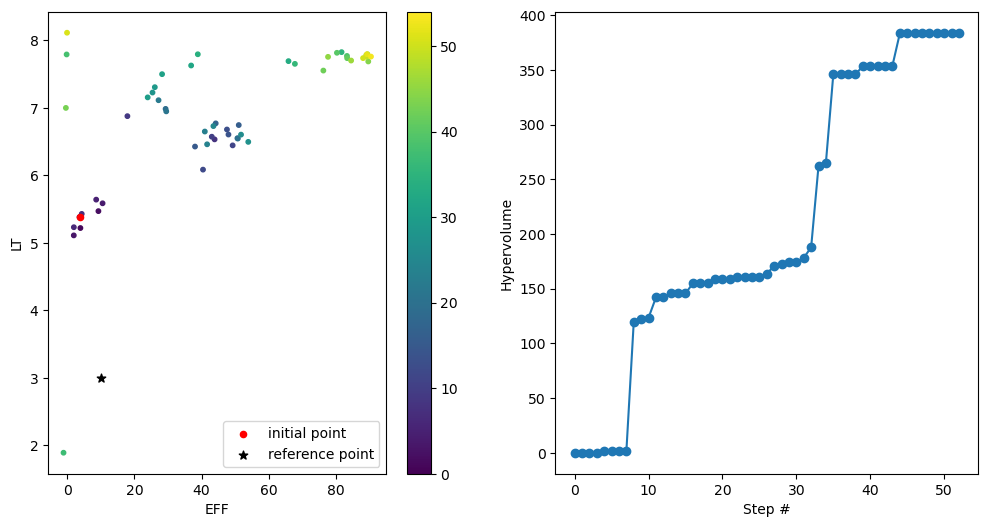

In [31]:
import matplotlib.pyplot as plt

hvs = []
for i in range(1,len(opt.data)):
    hv = opt.generator.calculate_hypervolume_at(i=i)
    hvs.append(hv)

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['EFF', 'LT']
l = ax[0,0].scatter(df.loc[:,ol[0]], df.loc[:,ol[1]],10,marker='o',c=range(len(df)),vmax=len(df))
ax[0,0].scatter(df.loc[:1,ol[0]], df.loc[:1,ol[1]], 20,marker='o',c='red',label='initial point')
ax[0,0].scatter(gen.reference_point[ol[0]], gen.reference_point[ol[1]],40,marker='*',c='black',label='reference point')
ax[0,0].set_xlabel(ol[0])
ax[0,0].set_ylabel(ol[1])
fig.colorbar(l)
ax[0,0].legend()

ax[0,1].plot(hvs,marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Hypervolume')

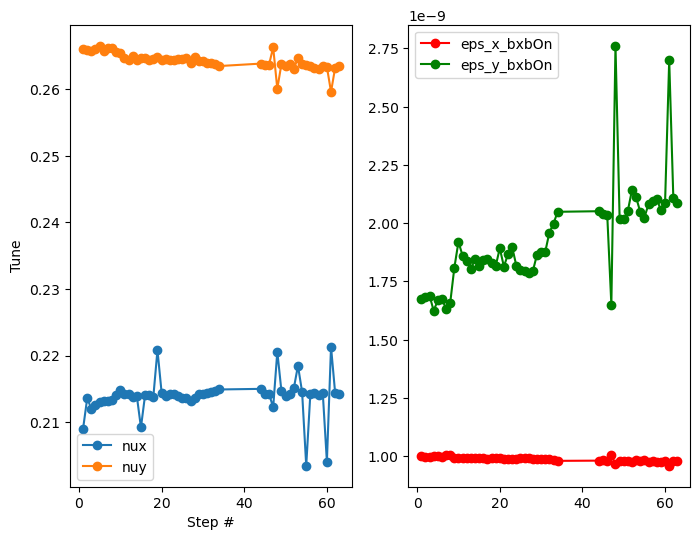

In [32]:
fig,ax = plt.subplots(1,2,squeeze=False,figsize=(8,6))
df = opt.data

ax[0,0].plot(df.loc[:,'_nux'], marker='o', label='nux')
ax[0,0].plot(df.loc[:,'_nuy'], marker='o', label='nuy')
ax[0,1].plot(df.loc[:,'_eps_x_bxbOn'], marker='o', label='eps_x_bxbOn', color='red')
ax[0,1].plot(df.loc[:,'_eps_y_bxbOn']*1e2, marker='o', label='eps_y_bxbOn', color='green')
ax[0,0].set_xlabel('Step #')
ax[0,0].set_ylabel('Tune')
ax[0,0].legend()
ax[0,1].legend()

In [27]:
for _ in range(8):
    opt.remove_last_step()

[DEBUG][00:13:34.095 optimizer.  829] Removing steps: [43]
[DEBUG][00:13:34.099 optimizer.  831] indices_to_remove=[43]
[DEBUG][00:13:34.100 optimizer.  142] Resetting generator class <class 'apsopt.algorithms.bayesian.mobo.APSMOBOGenerator'>
[INFO ][00:13:34.101 generator.   16] Initializing generator aps_mobo
[INFO ][00:13:34.102 generator.   64] Initialized generator aps_mobo
[DEBUG][00:13:34.106 optimizer.  138] Generator set to: supports_batch_generation=True supports_multi_objective=True vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1': [-0.31851854520000006, 0.31851854520000006], 'SL2-P1': [-0.8562701148, 0.8562701148], 'SL2-P2': [-0.8562701148, 0.8562701148], 'SL2-P3': [-0.8562701148, 0.8562701148], 'SL2-P4': [-0.8562701148, 0.8562701148], 'SL2-P5': [-0.8562701148, 0.8562701148], 'SL3-P1': [-0.70706065464, 0.70706065464], 'SL3-P2': [-0.70706065464, 0.70706065464], 'SL3

In [33]:
# Nominal (i.e., design) sextupole settings:
opt.generate_at({k:0.0 for k in variables.keys()})
opt.evaluate_data()

[INFO ][00:33:37.551 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:33:37.556 evaluators  193] Data kwargs: row={'SH1N': 0.0, 'SH3N': 0.0, 'SH4N': 0.0, 'SL1': 0.0, 'SL2-P1': 0.0, 'SL2-P2': 0.0, 'SL2-P3': 0.0, 'SL2-P4': 0.0, 'SL2-P5': 0.0, 'SL3-P1': 0.0, 'SL3-P2': 0.0, 'SL3-P3': 0.0, 'SL3-P4': 0.0, 'SL3-P5': 0.0, 'SH1-DW08': 0.0, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH3-DW08': 0.0, 'SH3-DW18': 0.0, 'SH3-DW28': 0.0, 'SH4-DW08': 0.0, 'SH4-DW18': 0.0, 'SH4-DW28': 0.0}
[INFO ][00:33:37.564 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.9665824200000004, 'SH3N': -1.171021682, 'SH4N': -3.164180142, 'SL1': -2.6543212100000004, 'SL2-P1': 7.135584290000001, 'SL2-P2': 7.135584290000001, 'SL2-P3': 7.135584290000001, 'SL2-P4': 7.135584290000001, 'SL2-P5': 7.135584290000001, 'SL3-P1': -5.892172122000001, 'SL3-P2': -5.892172122000001, 'SL3-P3': -5.892172122000001, 'SL3-P4': -5.892172122000001, 'SL3-P5': -5.892172122000001, 'SH1-DW08': 3.9665824200000004, 'SH1-DW18': 3.9665824200000004, 'SH1-DW28': 

SH1N   : +3.967 + +0.000 -> +3.967
SH3N   : -1.171 + +0.000 -> -1.171
SH4N   : -3.164 + +0.000 -> -3.164
SL1    : -2.654 + +0.000 -> -2.654
SL2-P1 : +7.136 + +0.000 -> +7.136
SL2-P2 : +7.136 + +0.000 -> +7.136
SL2-P3 : +7.136 + +0.000 -> +7.136
SL2-P4 : +7.136 + +0.000 -> +7.136
SL2-P5 : +7.136 + +0.000 -> +7.136
SL3-P1 : -5.892 + +0.000 -> -5.892
SL3-P2 : -5.892 + +0.000 -> -5.892
SL3-P3 : -5.892 + +0.000 -> -5.892
SL3-P4 : -5.892 + +0.000 -> -5.892
SL3-P5 : -5.892 + +0.000 -> -5.892
SH1-DW08: +3.967 + +0.000 -> +3.967
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.000 -> -1.171
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + +0.000 -> -1.171
SH4-DW08: -3.164 + +0.000 -> -3.164
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + +0.000 -> -3.164
Sextupole adj. took 9.3.
Max FCOR I [A] = 0.078; RMS(dx, dy) [m] = (4.896e-06, 1.157e-06)
Orbit correction converged


[INFO ][00:33:50.883 opt_funcs.  734] Lifetime measurement START
[INFO ][00:33:58.749 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.462 (raw tau [hr] = 9.608, epsy [pm] = 18.81) (took 7.9 [s])
Inj. Eff. = 60.33 (took 18.7 [s])
Eval. func. finished.


[DEBUG][00:34:17.439 evaluators  211] Result: output={'result': {'_nux': 0.21545277078463204, '_nuy': 0.26342611155866846, '_eps_x_bxbOn': 9.883014286008076e-10, '_eps_y_bxbOn': 1.9241738180160304e-11, '_eps_x_bxbOff': 9.852892504438587e-10, '_eps_y_bxbOff': 1.880500500646952e-11, 'LT': 7.461787737822058, '_raw_LT': 9.607517780393385, 'EFF': 60.32668847991619}, 'exception': None, 'traceback': '', 'wall_time': 39.882573168724775, 'cpu_time': 14.206014721996326}
[DEBUG][00:34:17.442 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:34:17.510 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00056.json] in [0.06396]s


In [34]:
opt.generate_at(iknobvals)
opt.evaluate_data()

[INFO ][00:34:17.526 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:34:17.528 evaluators  193] Data kwargs: row={'SH1N': -0.05, 'SH3N': 0.05, 'SH4N': -0.04, 'SL1': 0.08, 'SL2-P1': -0.27, 'SL2-P2': -0.34, 'SL2-P3': -0.41000000000000003, 'SL2-P4': -0.48000000000000004, 'SL2-P5': -0.55, 'SL3-P1': 0.13, 'SL3-P2': 0.06, 'SL3-P3': -0.010000000000000009, 'SL3-P4': -0.08000000000000002, 'SL3-P5': -0.15000000000000002, 'SH1-DW08': 0.025, 'SH1-DW18': -0.025, 'SH1-DW28': -0.025, 'SH3-DW08': 0.025, 'SH3-DW18': -0.025, 'SH3-DW28': -0.025, 'SH4-DW08': 0.025, 'SH4-DW18': -0.025, 'SH4-DW28': -0.025}
[INFO ][00:34:17.534 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.9165824200000006, 'SH3N': -1.1210216819999999, 'SH4N': -3.2041801420000002, 'SL1': -2.5743212100000004, 'SL2-P1': 6.865584290000001, 'SL2-P2': 6.795584290000001, 'SL2-P3': 6.7255842900000005, 'SL2-P4': 6.65558429, 'SL2-P5': 6.585584290000001, 'SL3-P1': -5.762172122000001, 'SL3-P2': -5.832172122000001, 'SL3-P3': -5.9021721220000005, 'SL

SH1N   : +3.967 + -0.050 -> +3.917
SH3N   : -1.171 + +0.050 -> -1.121
SH4N   : -3.164 + -0.040 -> -3.204
SL1    : -2.654 + +0.080 -> -2.574
SL2-P1 : +7.136 + -0.270 -> +6.866
SL2-P2 : +7.136 + -0.340 -> +6.796
SL2-P3 : +7.136 + -0.410 -> +6.726
SL2-P4 : +7.136 + -0.480 -> +6.656
SL2-P5 : +7.136 + -0.550 -> +6.586
SL3-P1 : -5.892 + +0.130 -> -5.762
SL3-P2 : -5.892 + +0.060 -> -5.832
SL3-P3 : -5.892 + -0.010 -> -5.902
SL3-P4 : -5.892 + -0.080 -> -5.972
SL3-P5 : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.025 -> +3.992
SH1-DW18: +3.967 + -0.025 -> +3.942
SH1-DW28: +3.967 + -0.025 -> +3.942
SH3-DW08: -1.171 + +0.025 -> -1.146
SH3-DW18: -1.171 + -0.025 -> -1.196
SH3-DW28: -1.171 + -0.025 -> -1.196
SH4-DW08: -3.164 + +0.025 -> -3.139
SH4-DW18: -3.164 + -0.025 -> -3.189
SH4-DW28: -3.164 + -0.025 -> -3.189
Sextupole adj. took 6.2.
Max FCOR I [A] = 0.092; RMS(dx, dy) [m] = (3.993e-06, 1.158e-06)
Orbit correction converged


[INFO ][00:34:27.767 opt_funcs.  734] Lifetime measurement START
[INFO ][00:34:32.651 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 7 (out of 180)
Lifetime = 5.648 (raw tau [hr] = 6.714, epsy [pm] = 16.01) (took 4.9 [s])
Inj. Eff. = 16.20 (took 17.4 [s])
Eval. func. finished.


[DEBUG][00:34:50.044 evaluators  211] Result: output={'result': {'_nux': 0.21215689541092217, '_nuy': 0.2645857742116001, '_eps_x_bxbOn': 9.907816875725717e-10, '_eps_y_bxbOn': 1.5935706486429768e-11, '_eps_x_bxbOff': 9.91749257647056e-10, '_eps_y_bxbOff': 1.6009476246240517e-11, 'LT': 5.648028835542109, '_raw_LT': 6.713666492035085, 'EFF': 16.202857344015626}, 'exception': None, 'traceback': '', 'wall_time': 32.515411025844514, 'cpu_time': 11.28122792099748}
[DEBUG][00:34:50.046 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:34:50.119 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-23_27_55-aps_mobo-7445a0f2c5-14c65bf4/dump_auto_00057.json] in [0.06896]s


In [35]:
with pd.option_context('display.max_rows', 500):
    display(opt.data)

,SH1N,SH3N,SH4N,SL1,SL2-P1,SL2-P2,SL2-P3,SL2-P4,SL2-P5,SL3-P1,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,-0.050000,0.050000,-0.040000,0.080000,-0.270000,-0.340000,-0.410000,-0.480000,-0.550000,0.130000,...,True,0.209029,0.266112,9.997528e-10,1.674262e-11,9.999940e-10,1.666845e-11,5.381570,5.983297,3.675760
2,-0.065021,0.049425,-0.033320,0.078414,-0.274419,-0.326761,-0.383080,-0.516050,-0.555427,0.098605,...,True,0.213591,0.265898,9.959390e-10,1.681572e-11,1.001875e-09,1.646861e-11,5.219646,5.775762,3.935742
3,-0.039967,0.056957,-0.044729,0.090330,-0.250348,-0.369410,-0.432534,-0.477599,-0.539566,0.152002,...,True,0.212004,0.265684,9.966005e-10,1.689482e-11,1.000102e-09,1.659772e-11,5.470122,6.062200,9.293796
4,-0.052725,0.051041,-0.054234,0.065323,-0.300607,-0.356132,-0.406070,-0.448165,-0.578889,0.142543,...,True,0.212615,0.266081,1.002726e-09,1.624252e-11,1.004139e-09,1.614822e-11,5.110581,5.609581,1.966361
5,-0.029994,0.044387,-0.023815,0.085264,-0.233720,-0.318506,-0.418230,-0.497319,-0.520118,0.124639,...,True,0.213032,0.266539,1.002302e-09,1.668814e-11,1.000327e-09,1.670756e-11,5.586228,6.229740,10.533115
6,-0.033728,0.052621,-0.026263,0.070753,-0.265488,-0.300905,-0.426206,-0.489363,-0.508268,0.130453,...,True,0.213225,0.265745,9.973195e-10,1.674996e-11,9.979438e-10,1.655864e-11,5.640609,6.279004,8.631946
7,-0.059433,0.045002,-0.056384,0.082726,-0.289582,-0.341537,-0.398180,-0.440170,-0.588732,0.112426,...,True,0.213133,0.266203,1.004693e-09,1.632509e-11,1.000167e-09,1.623319e-11,5.231435,5.770545,1.986964
8,-0.048156,0.046967,-0.046880,0.073643,-0.239297,-0.373216,-0.446030,-0.464253,-0.530387,0.104208,...,True,0.213256,0.266234,1.006082e-09,1.657493e-11,9.985585e-10,1.640904e-11,5.428987,6.013430,4.330554
9,0.034435,0.057188,0.017857,0.114305,-0.130647,-0.299703,-0.475114,-0.573760,-0.405651,0.181285,...,True,0.214079,0.265532,9.941572e-10,1.808021e-11,9.967907e-10,1.802457e-11,6.533912,7.569994,43.868129
10,0.092738,0.063810,0.055249,0.136100,-0.031663,-0.275158,-0.526678,-0.637883,-0.303471,0.210772,...,True,0.214812,0.265379,9.917866e-10,1.920021e-11,9.902222e-10,1.906792e-11,6.878134,8.254216,17.920351


In [36]:
opt.generator.model.state_dict()

OrderedDict([('models.0.likelihood.noise_covar.raw_noise',
              tensor([0.0002], dtype=torch.float64)),
             ('models.0.likelihood.noise_covar.noise_prior.concentration',
              tensor(1.1000, dtype=torch.float64)),
             ('models.0.likelihood.noise_covar.noise_prior.rate',
              tensor(0.0500, dtype=torch.float64)),
             ('models.0.likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04, dtype=torch.float64)),
             ('models.0.likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf, dtype=torch.float64)),
             ('models.0.mean_module.raw_constant',
              tensor(-0.9293, dtype=torch.float64)),
             ('models.0.covar_module.raw_outputscale',
              tensor(-0.8509, dtype=torch.float64)),
             ('models.0.covar_module.base_kernel.raw_lengthscale',
              tensor([[-0.6972, -0.9762, -0.4745, -2.3690, -0.5382, -0.5139, -0.4122, -0.4376,

In [37]:
# This will save optimizer state
if not TEST_MODE:
    opt.state_to_json(f'{datetime.now():%Y%m%dT%H%M%S}_{NAME_ROOT}_dump.json')